# Practical Session: Foundations of Machine Learning

In this assignment, you will be exploring linear regression models, and how regularization and optimization affect the parameters of your model.

In [399]:
import time
from copy import deepcopy

import pandas as pd
import numpy as np
import numpy.linalg as LA

import seaborn as sb
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

In [288]:
import warnings
warnings.filterwarnings('ignore')

## Step 1. Get the dataset:

<b>A.</b> Download the Combined Cycle Power Plant DataSet from the UCI repository.
The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant.
The dataset contains 9568 data points collected from a Combined Cycle Power Plant collected over 6 years (2006-2011), when the power plant was set to work with full load.
The task is to predict a real valued response named Net hourly electrical energy output (PE).

In [ ]:
# !curl -o ./CCPP.zip -k https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip

In [ ]:
# !unzip ./CCPP.zip -d .

<b>B.</b> Load the dataset using Pandas, preprocess the data and then make different visualizations of the dataset to identify the most predictive features.
Which features are most predictive? Why do you think so?

In [2]:
path = 'CCPP/Folds5x2_pp.xlsx'
xlsx = pd.ExcelFile(path)
CCPP = pd.read_excel(xlsx, 'Sheet1')

In [327]:
CCPP.head()

AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

In [328]:
CCPP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


### Feature Preprocessing 

In [329]:
# [Normalize]
df = CCPP - CCPP.min()
CCPP_norm = df/(CCPP.max()-CCPP.min())
CCPP_norm.head()

AT         V        AP        RH        PE
0  0.372521  0.291815  0.771591  0.638204  0.569536
1  0.662040  0.669039  0.671863  0.449330  0.319338
2  0.093484  0.249822  0.476862  0.892493  0.904636
3  0.539660  0.568683  0.429349  0.684718  0.347285
4  0.255241  0.216014  0.404355  0.952547  0.710464

In [330]:
# [Standardize]
df = CCPP - CCPP.mean()
CCPP_stdz = df/CCPP.std()
CCPP_stdz.head()

AT         V        AP        RH        PE
0 -0.629486 -0.987245  1.820393 -0.009519  0.521181
1  0.741870  0.681010  1.141803 -0.974570 -0.585634
2 -1.951195 -1.172956 -0.185068  1.289772  2.003574
3  0.162197  0.237191 -0.508366  0.228148 -0.462003
4 -1.185007 -1.322470 -0.678435  1.596616  1.144606

In [331]:
# [Norm+Stdz]
df = CCPP - CCPP.min()
CCPP_norm = df/(CCPP.max()-CCPP.min())
df = CCPP_norm - CCPP_norm.mean()
CCPP_scaled = df/CCPP_norm.std()
CCPP_scaled.head()

AT         V        AP        RH        PE
0 -0.629486 -0.987245  1.820393 -0.009519  0.521181
1  0.741870  0.681010  1.141803 -0.974570 -0.585634
2 -1.951195 -1.172956 -0.185068  1.289772  2.003574
3  0.162197  0.237191 -0.508366  0.228148 -0.462003
4 -1.185007 -1.322470 -0.678435  1.596616  1.144606

#### Visualization before preprocessing

In [336]:
%matplotlib inline

<AxesSubplot:>

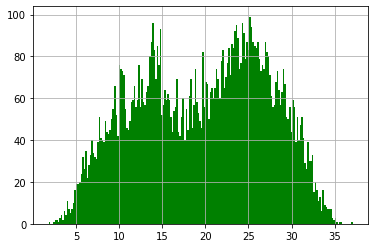

In [337]:
CCPP['AT'].hist(bins=200, color='g')

<AxesSubplot:>

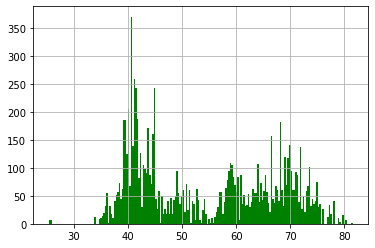

In [338]:
CCPP['V'].hist(bins=200, color='g')

<AxesSubplot:>

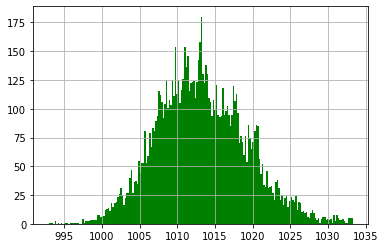

In [339]:
CCPP['AP'].hist(bins=200, color='g')

<AxesSubplot:>

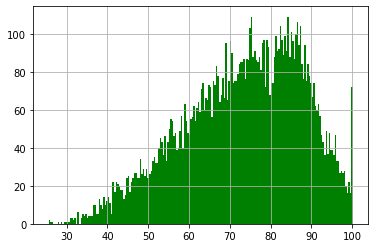

In [340]:
CCPP['RH'].hist(bins=200, color='g')

#### Visulaization after preprocessing [Standarization]

<AxesSubplot:>

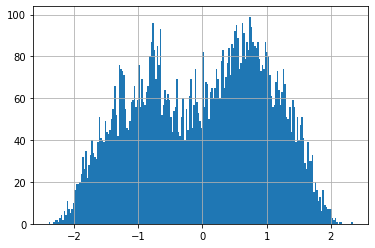

In [341]:
CCPP_stdz['AT'].hist(bins=200)

<AxesSubplot:>

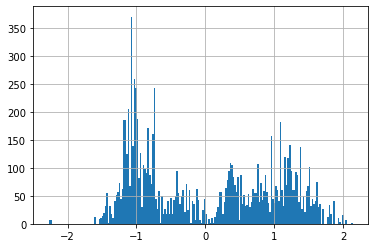

In [342]:
CCPP_stdz['V'].hist(bins=200)

<AxesSubplot:>

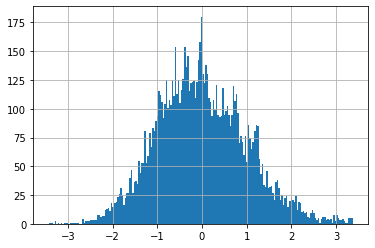

In [343]:
CCPP_stdz['AP'].hist(bins=200)

<AxesSubplot:>

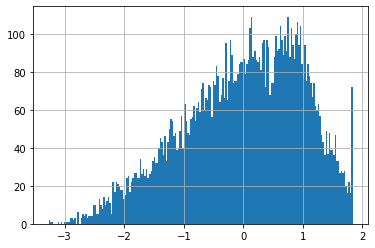

In [344]:
CCPP_stdz['RH'].hist(bins=200)

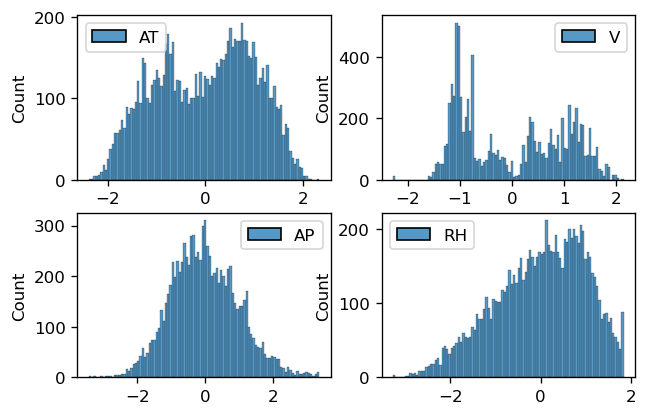

In [345]:
fig, ax = plt.subplots(2,2, dpi=120)
for x, axis in zip(CCPP_stdz.drop(['PE'], axis=1), ax.flat):
    sb.histplot(CCPP_stdz[[f'{x}']], bins=100, ax=axis)

### Features Visualization

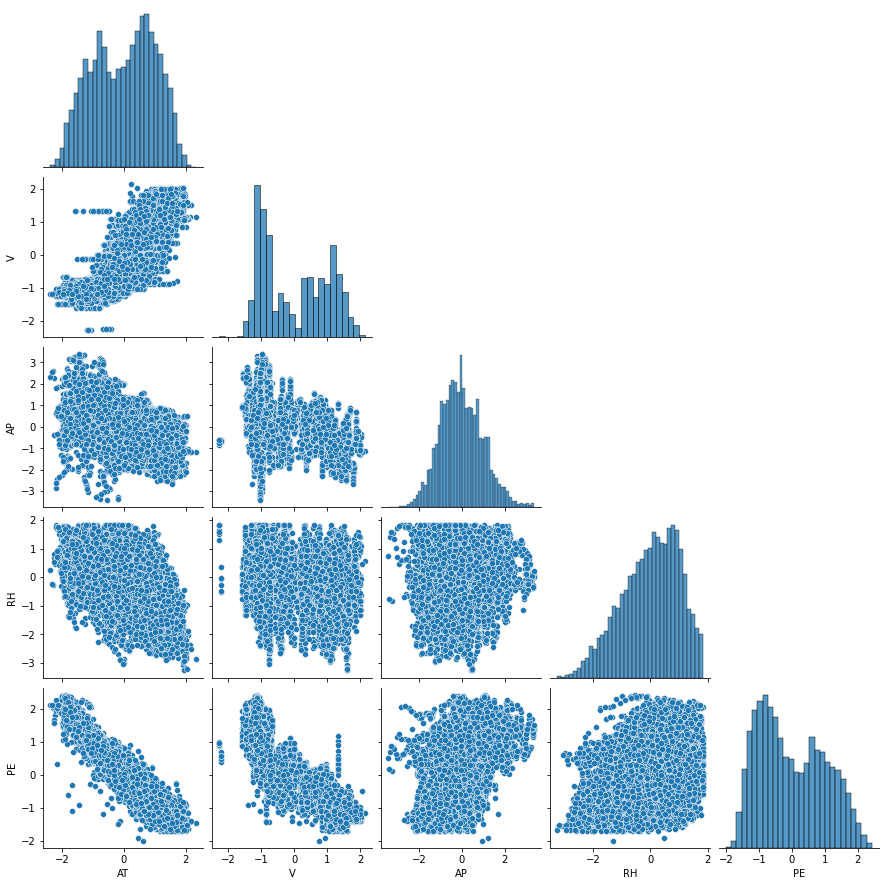

In [346]:
sb.pairplot(CCPP_stdz, corner=True)

In [347]:
CCPP_corr = CCPP_scaled.corr()
CCPP_corr

AT         V        AP        RH        PE
AT  1.000000  0.844107 -0.507549 -0.542535 -0.948128
V   0.844107  1.000000 -0.413502 -0.312187 -0.869780
AP -0.507549 -0.413502  1.000000  0.099574  0.518429
RH -0.542535 -0.312187  0.099574  1.000000  0.389794
PE -0.948128 -0.869780  0.518429  0.389794  1.000000

<AxesSubplot:>

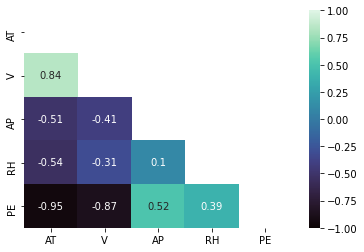

In [348]:
mask = np.triu(np.ones_like(CCPP_corr, dtype=np.bool))
sb.heatmap(CCPP_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='mako')

<b>[ Answers ]</b><br>
&emsp; From above (in PairPlot and Correlation HeatMap),we notice that the most precictive features are ordered based on thier correlation with the output (PE):
<br>
&emsp; &emsp; 1.AT<br>
&emsp; &emsp; 2.V<br>
&emsp; &emsp; 3.AP<br>
&emsp; &emsp; 4.RH<br>

<b>C.</b> Writeadataloaderfunction/classthattakesapandasdataframeandsplitpercentage (ratio) as input arguments and returns the splits of the data.
e.g x_train, x_test,y_train, y_test = split_data(df, split_percent=0.2)
Do not forget to shuffle the data before splitting.

In [349]:
class DataLoader:
    def __init__(self, seed=0):
        np.random.seed(seed) # to have consisten results when repeating the experiment
        
    def add_bias(self, Z):
        Z_bias = np.ones([Z.shape[0],Z.shape[1]+1])
        Z_bias[:,1:] = Z
        return Z_bias
    
    def add_features(self, f_order, X):
        highers = []
        for n in range(1, f_order+1):
            X_n = X**n
            if n > 1:
                for i in X_n.columns:
                    X_n.rename(columns={f'{i}': f'{i}^{n}'}, inplace=True)
            highers.append(X_n)
    
        return pd.concat([*highers], axis=1).to_numpy()
        
        
    def shuffle(self, df):
        shuffled = df.sample(
                            frac=1, 
                            random_state=np.random.randint(0,1000)
                            ).reset_index(drop=True)
        return shuffled
    
    def normalize(self, df, target, hist=False):
        df_ = df - df.min()
        normalized = df_/(df.max()-df.min())
        normalizedX = normalized
        normalizedX[f'{target}'] = df[f'{target}']
        if hist:
            fig, ax = plt.subplots(2,2, dpi=120)
            for x, axis in zip(normalizedX(['PE'], axis=1), ax.flat):
                sb.histplot(normalizedX[[f'{x}']], bins=100, ax=axis)
        return normalizedX
    
    def standarize(self, df, target, hist=False):
        df_ = df - df.mean()
        standardized = df_/df.std()
        standardizedX = standardized
        standardizedX[f'{target}'] = df[f'{target}']
        if hist:
            fig, ax = plt.subplots(2,2, dpi=120)
            for x, axis in zip(standardizedX.drop(['PE'], axis=1), ax.flat):
                sb.histplot(standardizedX[[f'{x}']], bins=100, ax=axis)
        return standardizedX
    
    def preprocess(self):
        pass
    
    def df2xy(self, df, target, f_order=1, bias=False):
        X = df.drop([f'{target}'], axis=1)
        if bias:
            X = self.add_bias(X)
        Y = df[f'{target}']
        return X, Y
    
    def df2xy_np(self, df, target, f_order=1, bias=True):
        X = df.drop([f'{target}'], axis=1)
        if f_order >1:
            X = self.add_features(f_order, X)
        if bias:
            X = self.add_bias(X)
            
        Y = df[f'{target}'].to_numpy().reshape(-1,1)
        return X, Y
    
    def split_data(self, df, split_percent=0.2):
        df = self.shuffle(df)
        
        test_len = round(split_percent*len(df))
        train_len = len(df) - test_len
        
        D_train = df.head(train_len)
        D_test = df.tail(test_len)
        
        return D_train, D_test
    
    def split_data2xy(self, df, target, split_percent=0.2):
        df = self.shuffle(df)
        
        test_len = round(split_percent*len(df))
        train_len = len(df) - test_len
        
        D_train = df.head(train_len)
        D_test = df.tail(test_len)
        
        Xtrain, Ytrain = self.df2xy(D_train, target)
        Xtest, Ytest = self.df2xy(D_test, target)
        
        return Xtrain, Ytrain, Xtest, Ytest
    
    def split_K(self, df, K, k):
        assert 0 < k <= K
        N = len(df)//K
        val = df.iloc[(k-1)*N:k*N].reset_index(drop=True)
        train = df.drop(df.index[(k-1)*N:k*N]).reset_index(drop=True)
        return train, val

In [350]:
dl = DataLoader()

In [351]:
D_train, D_test = dl.split_data(CCPP_scaled, split_percent=0.2)
D_train.head()

AT         V        AP        RH        PE
0 -1.211843 -1.154070 -0.439329 -0.764299  1.330345
1 -1.478869 -0.827502  0.475000  0.680879  1.731118
2  0.127309  0.850983  0.382388 -0.119106 -0.088182
3 -1.042772 -1.001409  0.555825  1.155528  0.650671
4  0.454717  0.784095  0.173591  0.474034 -0.861019

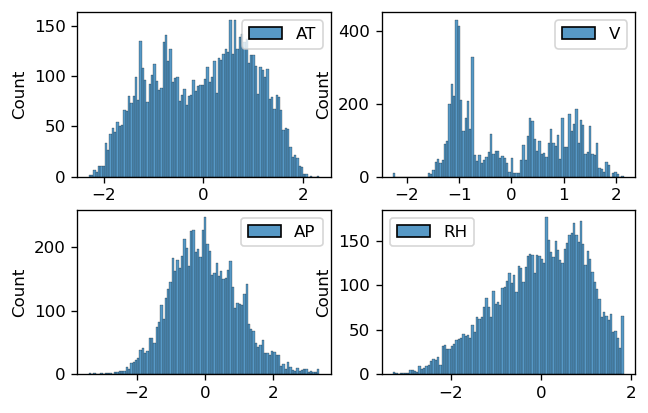

In [352]:
_ = dl.standarize(D_train, 'PE', hist=True)

In [354]:
Xtrain, Ytrain, Xtest, Ytest = dl.split_data2xy(CCPP, 'PE', split_percent=0.2)

In [355]:
Xtrain.head()

AT      V       AP     RH
0  14.79  38.73   999.83  86.45
1  21.89  45.38  1014.42  68.95
2  29.70  67.17  1007.31  66.56
3  25.95  63.47  1011.77  66.22
4   6.71  39.37  1020.28  71.15

In [356]:
dl.shuffle(Xtrain).head()

AT      V       AP     RH
0  14.36  41.26  1021.16  73.43
1  14.13  41.23   994.60  93.02
2  31.20  73.17  1010.28  53.23
3   6.52  35.57  1025.37  78.32
4  19.98  56.53  1020.22  73.53

## Step 2. Model Implementation

We will be creating Linear Regression models using gradient descent, SGD and minibatch GD. You can follow the structure of your previous assignment if need be.

<b>D.</b> CreateaLinearRegressionModelclassthatusesbatchgradientdescent(BGD). The BGD uses all the data for computing the gradient on every iteration. Your class should take at least the two hyper-parameters, number of iterations and learning rate, necessary for building the model.

<b>E.</b> CreateaLinearRegressionModelusingStochasticGradientDescent.Thisusesone sample at every iteration for gradient descent. Also include hyper-parameters for the model.

<b>F.</b> Create a Linear Regression Model using Mini-Batch Gradient Descent. This uses a batch, b < total number of samples on each gradient update. Include the batch size as a hyper-parameter to your model.

<b>G.</b> For each of the models, fit the train samples and predict on the test samples. Use any split percentage of your choice. Ensure your models and hyper-parameters are working as they should. An easy way to do this is to compute the MSE for each model.

### Helper Functions

Why we divide the squared loss by (2*N)?<br>
https://math.stackexchange.com/questions/884887/why-divide-by-2m

In [357]:
def MSE(theta, X, Y):
    return (np.square(X@theta-Y).sum()/(2*len(Y)))

In [358]:
def gradMSE(theta, X, Y):
    return X.T@(X@theta - Y)/len(Y)

In [359]:
def GradDescent(name, D_train, D_test, target, bias,
                loss, grad,
                lr, nEpochs, bs,
                plot=False):
    '''
    lr: learning rate
    bs: batch size
    
    '''
    if bias:
        d = D_train.drop([f'{target}'], axis=1).shape[1]+1
    else:
        d = D_train.drop([f'{target}'], axis=1).shape[1]
        
#     theta = np.zeros([d,1]) # zeros
    theta = np.random.random([d,1]) # rands
    
    if bs == 'All':
        bs = len(D_train)
        nIter = 1
    else:
        nIter = len(D_train)//bs
        
    if plot:
        fig = plt.figure(figsize=(10, 5), dpi=150)
        ax = fig.add_subplot(1, 1, 1)
    
    E = []
    mse_train = []
    mse_test = []
    
    for ep in range(nEpochs):
        
        D_ = dl.shuffle(D_train)
        D = dl.standarize(D_, target)
        X, Y = dl.df2xy_np(D, target, bias)
        error = 0
        for i in range(nIter):
            X_batch, Y_batch = X[i*bs:(1+i)*bs], Y[i*bs:(1+i)*bs]
            gradLoss = grad(theta, X_batch, Y_batch)
            theta = theta - lr*gradLoss
            error += loss(theta, X_batch, Y_batch)
            
        E.append(ep)
        mse_train.append(error/nIter)
        
        
        D_ = dl.shuffle(D_test)
        D = dl.standarize(D_, target)
        X, Y = dl.df2xy_np(D, target, bias=True)
        test_error = loss(theta, X, Y)
        mse_test.append(test_error)
        
        if plot:
            ax.cla()
            ax.set_title(f'{name} Error, Epoch: {ep}', fontsize=15)
            ax.set_xlim(0, ep)
    #         ax.set_ylim(0, max(max(mse_train),max(mse_test)))
    #         ax.set_ylim(0,1.5)
            ax.grid(True)
            ax.plot(E, mse_train, 'b', label=f'MSE-train {round(error/nIter, 4)}')
            ax.plot(E, mse_test, 'r', label=f'MSE-test  {round(test_error, 4)}')
            ax.legend(loc='upper right', fontsize=15)
            plt.tight_layout()
            display(fig)
            clear_output(wait = True)
        else:
            print(f'Epoch: {ep}, MSE-train: {round(error, 4)}, MSE-train: {round(test_error, 4)}', end='\r')
    
    return theta, mse_train, mse_test

### Linear Regression Model

In [360]:
class LinearRegression:
    def __init__(self, bias=True, bs='All', lr=0.01, nEpochs=5, seed=0):
        self.bias = bias
        self.bs = bs
        self.lr = lr
        self.nEpochs = nEpochs
        np.random.seed(seed)

    def fit(self, Data, sp_pr, target, loss, grad, plot=True):
        if self.bs == 'All':
            self.name = 'Batch Gradient Descent'
        elif self.bs == 1:
            self.name = 'Stochastic Gradient Descent'
        else:
            self.name = 'mini Batch Gradient Descent'
        
        D_train, D_test = dl.split_data(Data, split_percent=sp_pr)
        
        self.theta, mse_train, mse_test = GradDescent(self.name,
                                                      D_train,
                                                      D_test,
                                                      target,
                                                      self.bias,
                                                      loss,
                                                      grad,
                                                      self.lr,
                                                      self.nEpochs,
                                                      self.bs,
                                                      plot)
        return D_train, mse_train, D_test, mse_test, self.theta
    
    def predict(self, X):
        return X@self.theta
    
    def plot_model(self, D_test, target):
        plt.figure(figsize=(15,2), dpi=150)
        
        D_ = dl.shuffle(D_test)
        D = dl.standarize(D_, target)
        X, Y = dl.df2xy_np(D, target, bias=self.bias)
        Y_hat = X@self.theta
        
        N = np.linspace(0, len(Y), len(Y))
        plt.plot(N, Y_hat, 'g', label='Ground Truth')
        plt.plot(N, Y, 'b', label='Predictions')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.title(f'{self.name}')
        

#### Batch Gradient Descent

In [361]:
lr = 0.01
nEpochs = 100
LinReg_GD = LinearRegression(lr=lr, nEpochs=nEpochs)

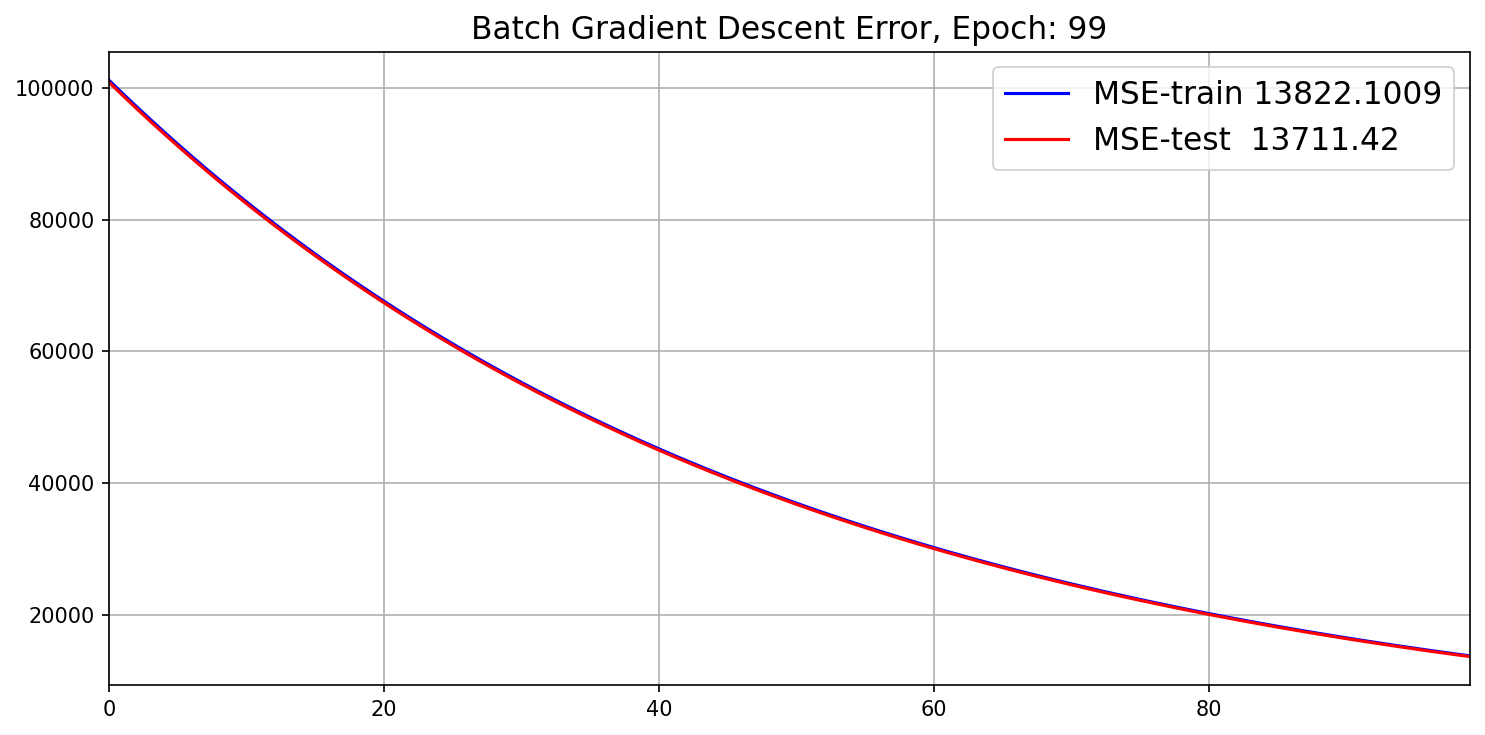

In [362]:
D_train, mse_train,\
D_test, mse_test,\
theta = LinReg_GD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradMSE,
                       plot=True)

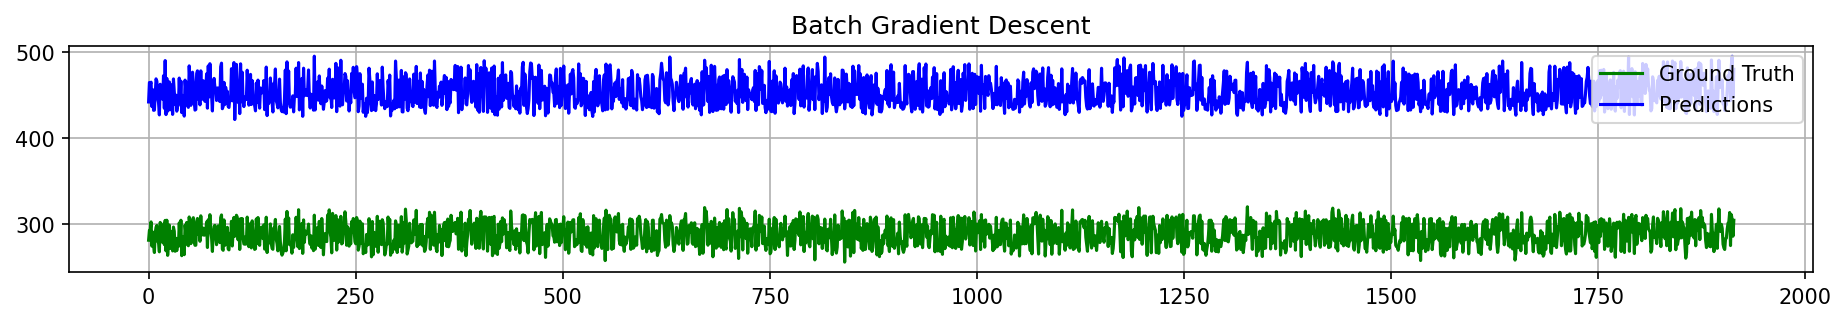

In [363]:
LinReg_GD.plot_model(D_test, 'PE')

#### Stochastic Gradient Descent

In [364]:
lr = 0.01
nEpochs = 100
LinReg_SGD = LinearRegression(bs=1, nEpochs=nEpochs)

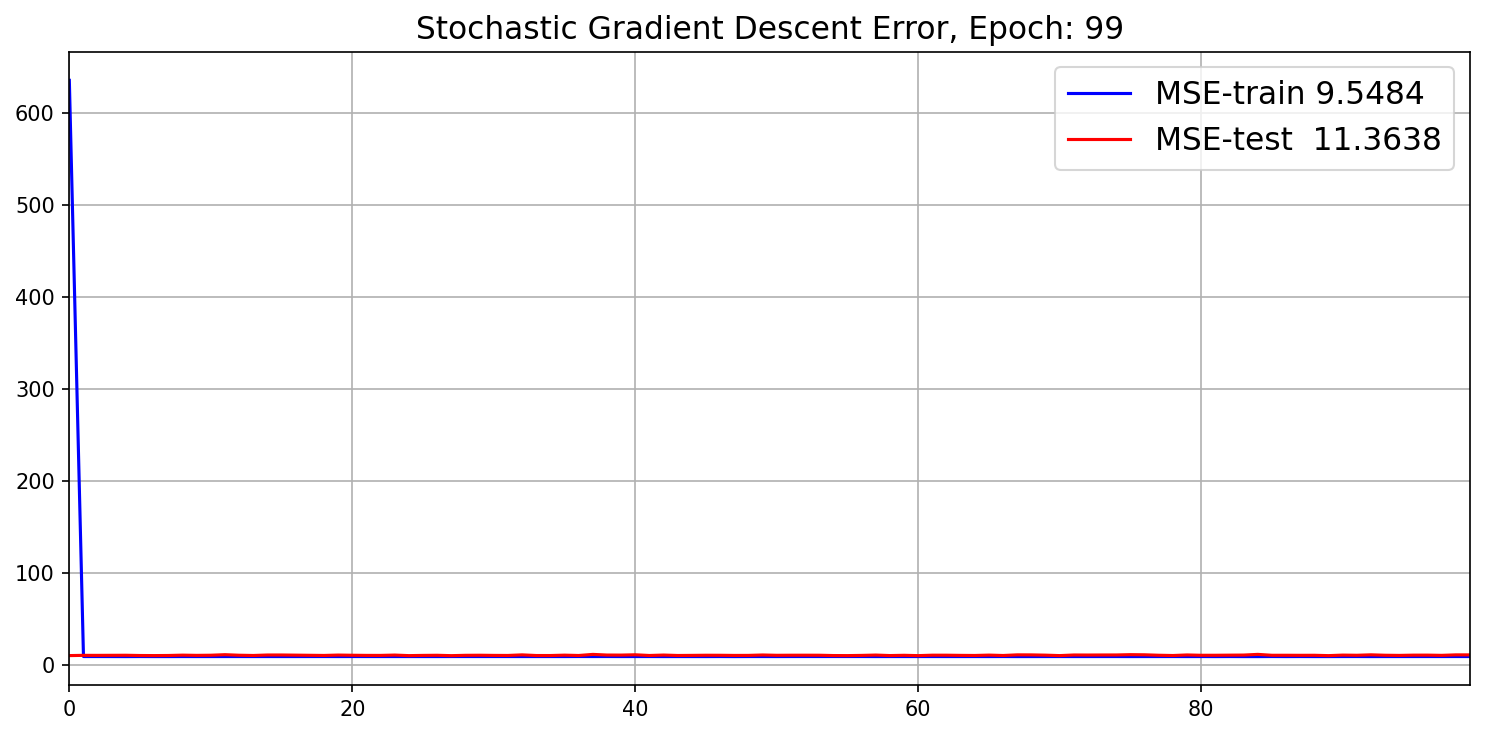

In [365]:
D_train, mse_train,\
D_test, mse_test,\
theta = LinReg_SGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradMSE,
                       plot=True)

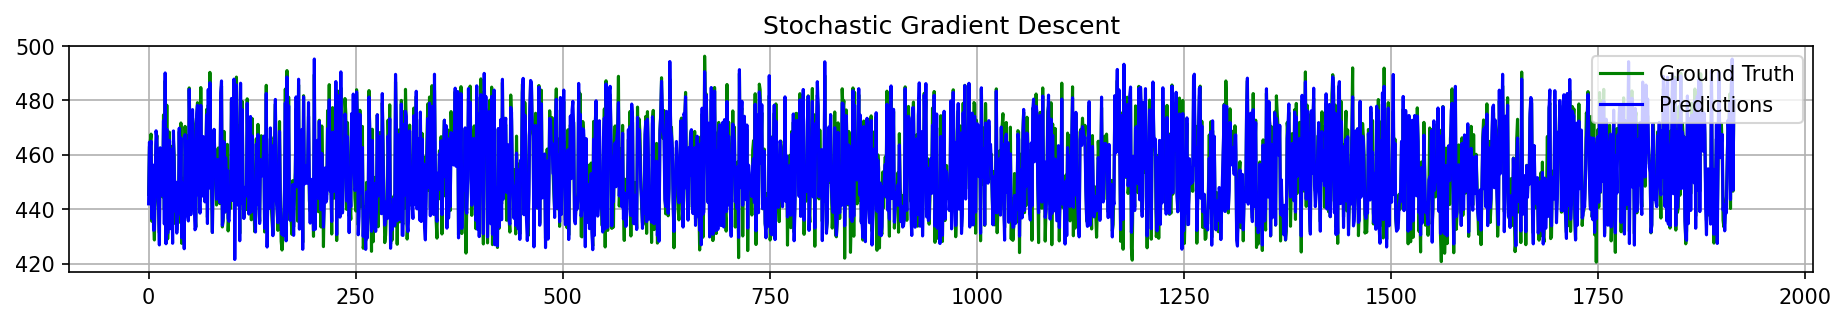

In [366]:
LinReg_SGD.plot_model(D_test, 'PE')

#### mini Batch Gradient Descent

In [367]:
lr = 0.01
nEpochs = 100
LinReg_mBGD = LinearRegression(bs=100, lr=lr, nEpochs=nEpochs)

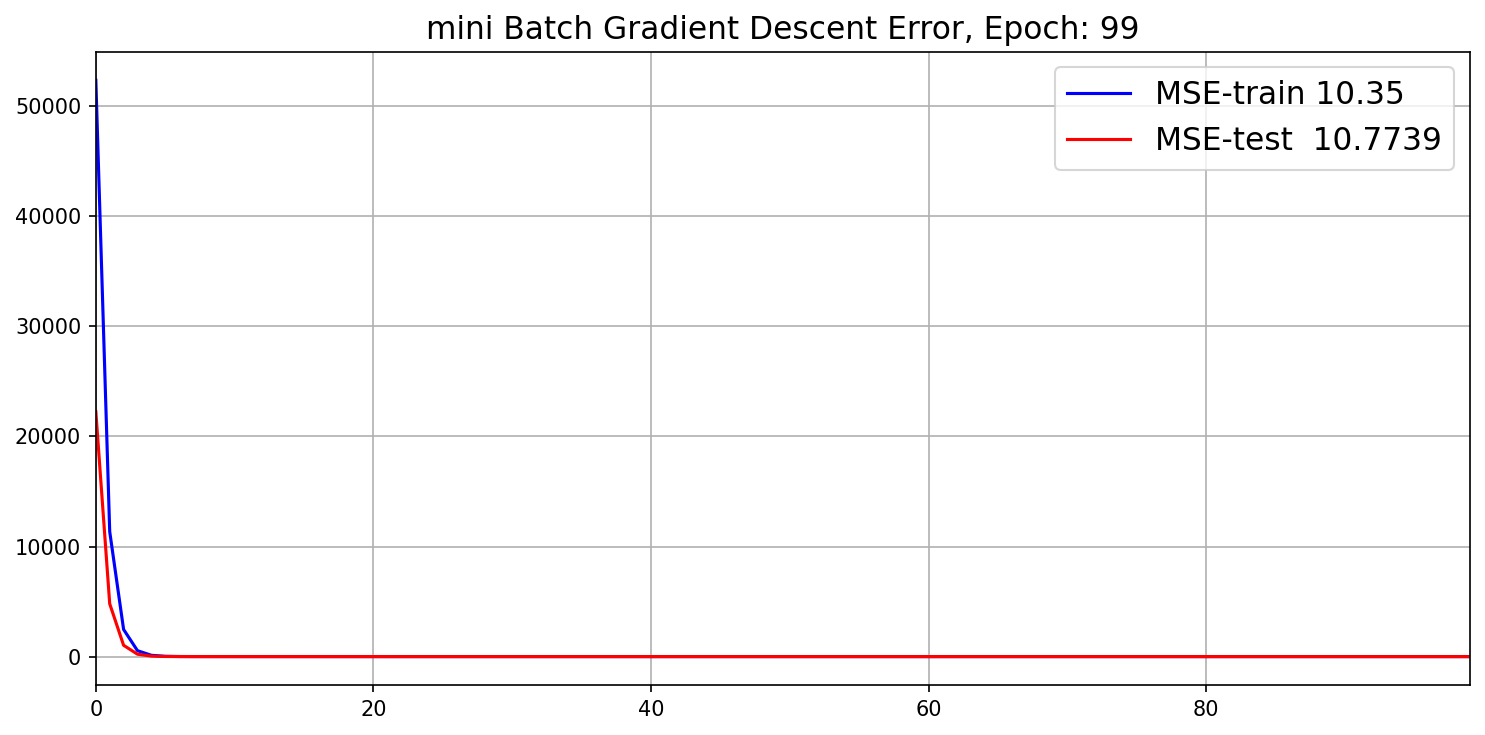

In [368]:
D_train, mse_train,\
D_test, mse_test,\
theta = LinReg_mBGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradMSE,
                       plot=True)

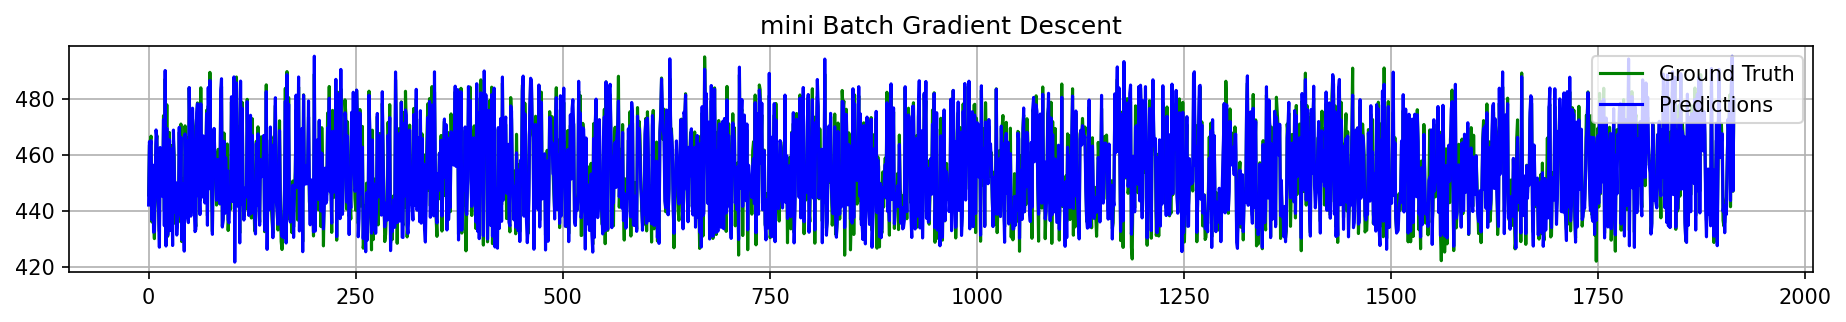

In [369]:
LinReg_mBGD.plot_model(D_test, 'PE')

## Step 3: Fitting the model

Now that we have written our base models, we can now test the effects of different hyperparameters and regularization on the model.

<b>H.</b> Createcopiesofyourmodelsabove.Updatethesemodelstotakeanadditional hyper-parameter, regularizer. For each copied model, implement the<br>
i) L1-regularization,<br>
ii) L2-regularization,<br>
iii) Linear combination of L1 and L2 regularization: ${λ_{1}||θ||_{2}^2}$ + ${λ_{2}||θ||_{1}}$ (You can read about Elastic Net).<br>
Remember that the gradient of the loss function changes because of the regularization term. Derive the gradient update for each regularization and implement it.

<b>[ Solution ]</b><br>
&emsp; I'd like to start by creating a general optmization for both regulaizers (the Elastic Net), and derive its gradient, and in the case of using one regularizer we set the the weight of the other to zero.
So, the Elastic Net loss will be,<br>
$${ Loss(\theta) = \frac{1}{2N} ( ||Xθ - Y||_{2}^2 + λ_{L2}||θ||_{2}^2 + λ_{L1}||θ||_{1}) }$$
and the gradient is,
$${ \nabla_{\theta} Loss(\theta) = \frac{1}{2N} ( 2 X^T(Xθ - Y) + 2 λ_{L2}θ + λ_{L1} ) }$$

<!-- We divide by N the whole term to assure that λ_{L2} and λ_{L1} will be the only parameter that control the relationship between the  -->

In [370]:
def ElasticNetLoss(theta, X, Y, lambdaL2, lambdaL1):
    N = len(Y)
    lossSE = np.square(LA.norm(X@theta-Y))
    lossL2 = np.square(LA.norm(theta))
    lossL1 = LA.norm(theta, 1)
    return (1/(2*N)) * (lossSE + lambdaL2*lossL2 + lambdaL1*lossL1)

In [371]:
def gradEN(theta, X, Y, lambdaL2, lambdaL1):
    N = len(Y)
    return (1/N) * (X.T@(X@theta-Y) + 2*lambdaL2*theta + lambdaL1)

In [372]:
def GDGeneral(reg_name, D_train, D_test, target, bias, f_order,
                loss, grad, lambdaL2, lambdaL1,
                lr, nEpochs, bs,
                plot=False):
    '''
    lr: learning rate
    bs: batch size
    
    '''
    if bias:
        d = f_order*(D_train.drop([f'{target}'], axis=1).shape[1])+1
    else:
        d = f_order*(D_train.drop([f'{target}'], axis=1).shape[1])
        
#     theta = np.zeros([d,1]) # zeros
    theta = np.random.random([d,1]) # rands
    
        
    if bs == 'All':
        bs = len(D_train)
        nIter = 1
        name = 'BGD'
    elif bs == 1:
        nIter = len(D_train)//bs
        name = 'SGD'
    else:
        nIter = len(D_train)//bs
        name = 'mBGD'

        
    if plot:
        fig = plt.figure(figsize=(10, 5), dpi=150)
        ax = fig.add_subplot(1, 1, 1)
    
    E = []
    mse_train = []
    mse_test = []
    
    for ep in range(nEpochs):
        
        D_ = dl.shuffle(D_train)
        D = dl.standarize(D_, target)
        X, Y = dl.df2xy_np(D, target, f_order, bias)
        error = 0
        for i in range(nIter):
            X_batch, Y_batch = X[i*bs:(1+i)*bs], Y[i*bs:(1+i)*bs]
            gradLoss = grad(theta, X_batch, Y_batch, lambdaL2, lambdaL1)
            theta = theta - lr*gradLoss
            error += loss(theta, X_batch, Y_batch)
            
        E.append(ep)
        mse_train.append(error/nIter)
        
#         if D_test:
        D_ = dl.shuffle(D_test)
        D = dl.standarize(D_, target)
        X, Y = dl.df2xy_np(D, target, f_order, bias=True)
        test_error = loss(theta, X, Y)
        mse_test.append(test_error)
#         else:
#             test_error = None
        
        if plot:
            ax.cla()
            ax.set_title(f"{reg_name}, {name}, Order: {f_order},  λL1: {round(lambdaL1, 4)},  λL2: {round(lambdaL2, 4)},  Error, Epoch: {ep}", fontsize=15)
            ax.set_xlim(0, ep)
            ax.grid(True)
            ax.plot(E, mse_train, 'b', label=f'MSE-train {round(error/nIter, 4)}')
            ax.plot(E, mse_test, 'r', label=f'MSE-test  {round(test_error, 4)}')
            ax.legend(loc='upper right', fontsize=15)
            plt.tight_layout()
            display(fig)
            clear_output(wait = True)
        else:
            print(f"{reg_name}, {name}, Order: {f_order}, λL1: {round(lambdaL1, 4)}, λL2: {round(lambdaL2, 4)}, Epoch: {ep}, MSE-train: {round(error, 4)}, MSE-train: {round(test_error, 4)}", end='\r')
    
    return theta, mse_train, mse_test

In [373]:
class LRGeneral:
    def __init__(self, f_order=1, bias=True, bs='All', lr=0.01, nEpochs=5, lambdaL2=0, lambdaL1=0, seed=0):
        self.f_order = f_order
        self.bias = bias
        self.bs = bs
        self.lr = lr
        self.nEpochs = nEpochs
        self.lambdaL2 = lambdaL2
        self.lambdaL1 = lambdaL1
        np.random.seed(seed)

    def fit(self, Data, sp_pr, target, loss, grad, plot=True):
        if self.lambdaL2 == 0 and self.lambdaL1 == 0:
            self.name = 'Linear Regression'
        if self.lambdaL2 != 0 and self.lambdaL1 == 0:
            self.name = 'Ridge Regression'
        elif self.lambdaL1 != 0 and self.lambdaL2 == 0:
            self.name = 'Lasso Regression'
        else:
            self.name = 'Elastic Net Regression'
        
#         if sp_pr > 0:
        D_train, D_test = dl.split_data(Data, split_percent=sp_pr)
#         else:
#             D_train, D_test = Data, None
            
        self.theta, mse_train, mse_test = GDGeneral(self.name,
                                                    D_train,
                                                    D_test,
                                                    target,
                                                    self.bias,
                                                    self.f_order,
                                                    loss,
                                                    grad,
                                                    self.lambdaL2,
                                                    self.lambdaL1,
                                                    self.lr,
                                                    self.nEpochs,
                                                    self.bs,
                                                    plot)
        return D_train, mse_train, D_test, mse_test, self.theta
    
    def predict(self, X):
        return X@self.theta
    
    def test_model(self, D_test, target, loss):
        D_ = dl.shuffle(D_test)
        D = dl.standarize(D_, target)
        X, Y = dl.df2xy_np(D, target, bias=self.bias)
        return loss(theta, X, Y)
    
    def plot_model(self, D_test, target):
        plt.figure(figsize=(15,2), dpi=150)
        
        D_ = dl.shuffle(D_test)
        D = dl.standarize(D_, target)
        X, Y = dl.df2xy_np(D, target, bias=self.bias)
        Y_hat = X@self.theta
        
        N = np.linspace(0, len(Y), len(Y))
        plt.plot(N, Y_hat, 'g', label='Ground Truth')
        plt.plot(N, Y, 'b', label='Predictions')
        plt.grid(True)
        plt.legend(loc='upper right', fontsize=15)
        plt.title(f'{self.name}', fontsize=15)
        

<b>i)</b> L1-regularization,<br>

In [374]:
LR_L1_GD = LRGeneral(lambdaL1=0.5, lambdaL2=0, lr=0.01, nEpochs=100)
LR_L1_SGD = LRGeneral(bs=1, lambdaL1=0.5, lambdaL2=0, lr=0.01, nEpochs=100)
LR_L1_mBGD = LRGeneral(bs=100, lambdaL1=0.5, lambdaL2=0, lr=0.01, nEpochs=100)

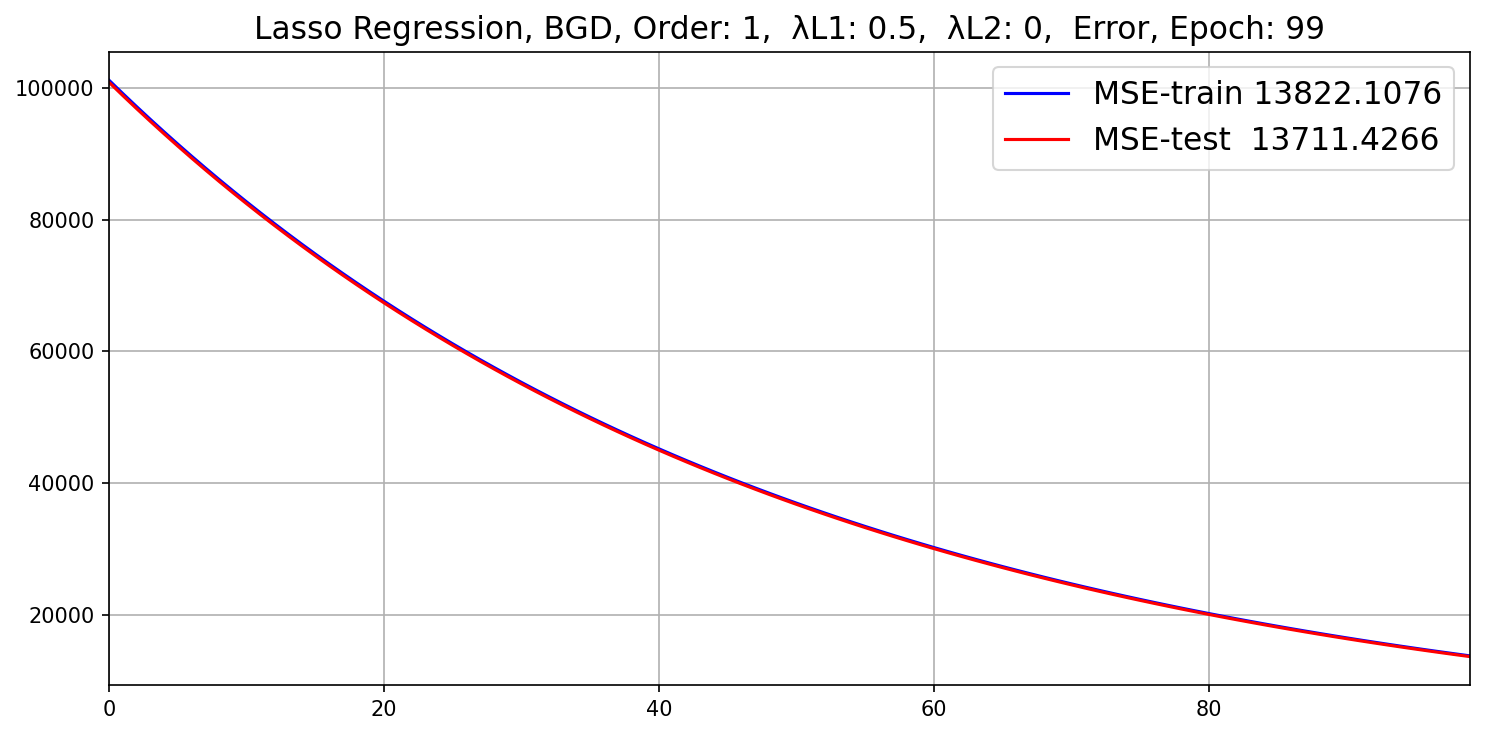

In [375]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_L1_GD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

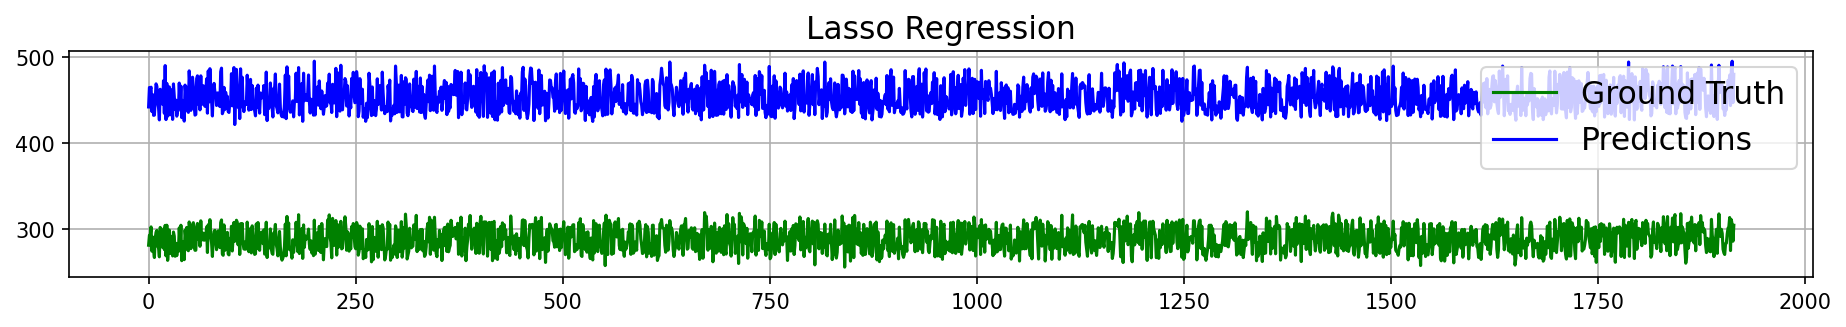

In [376]:
LR_L1_GD.plot_model(D_test, 'PE')

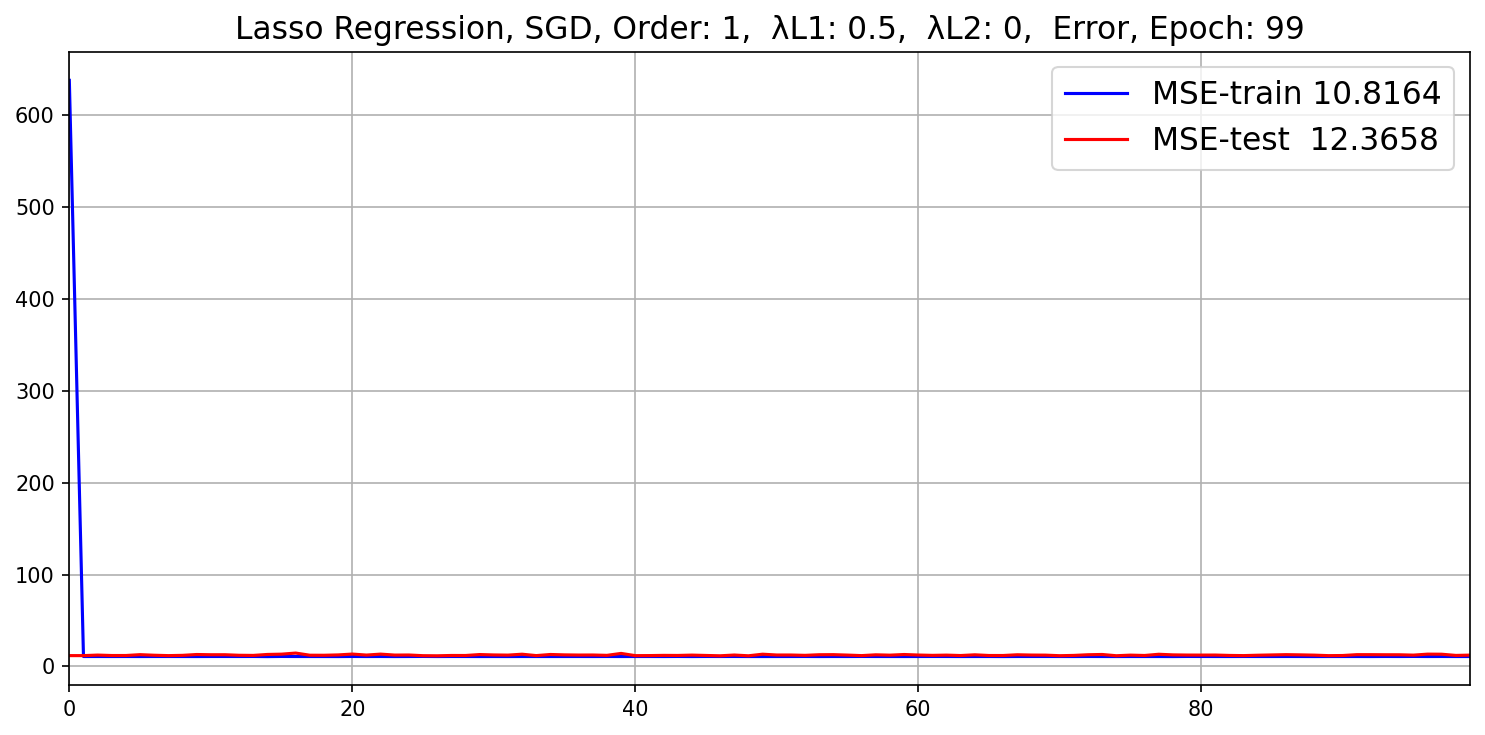

In [377]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_L1_SGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

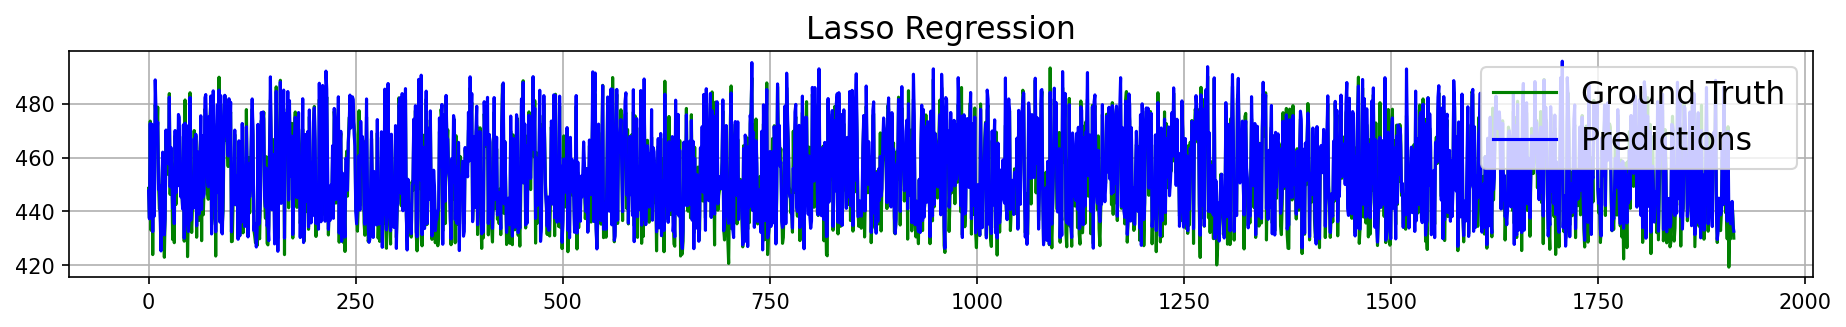

In [378]:
LR_L1_SGD.plot_model(D_test, 'PE')

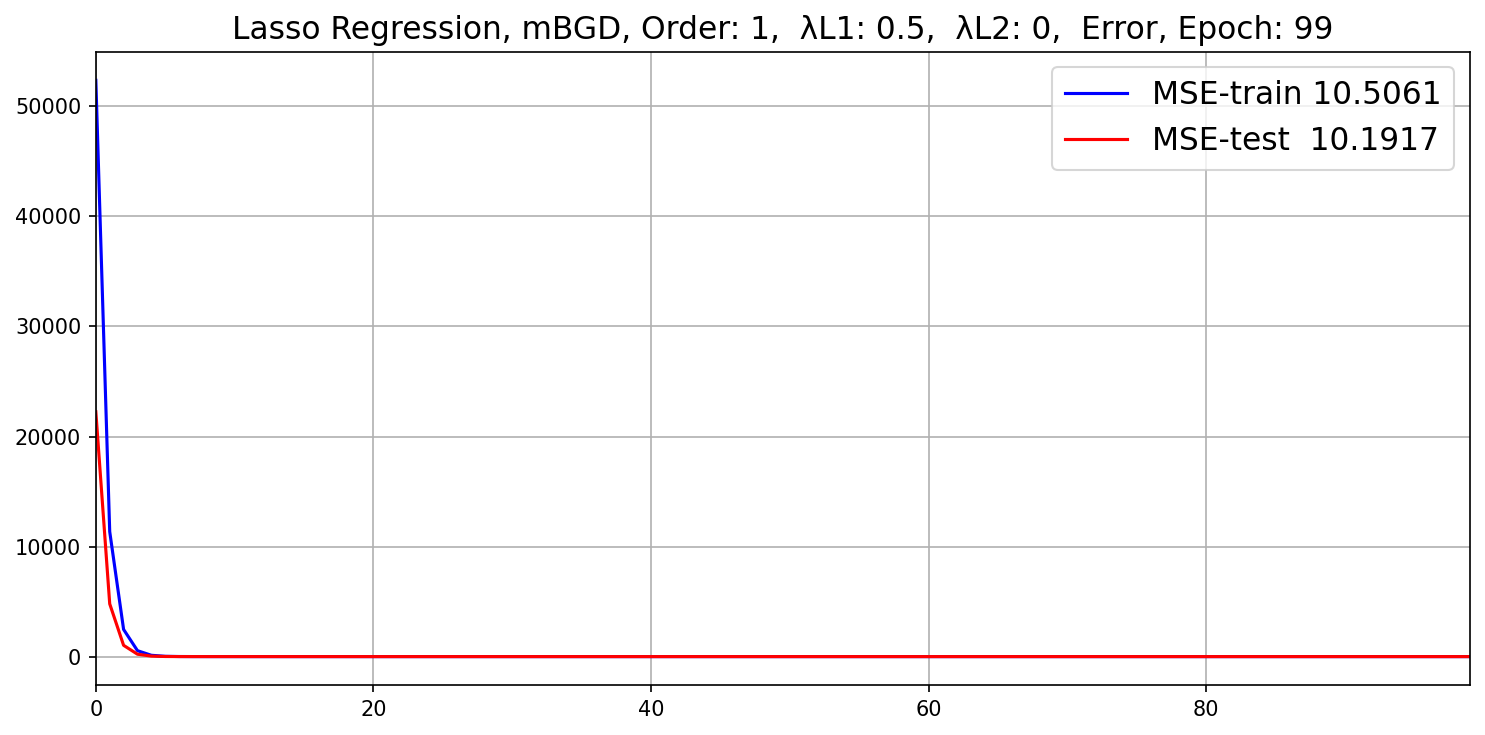

In [379]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_L1_mBGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

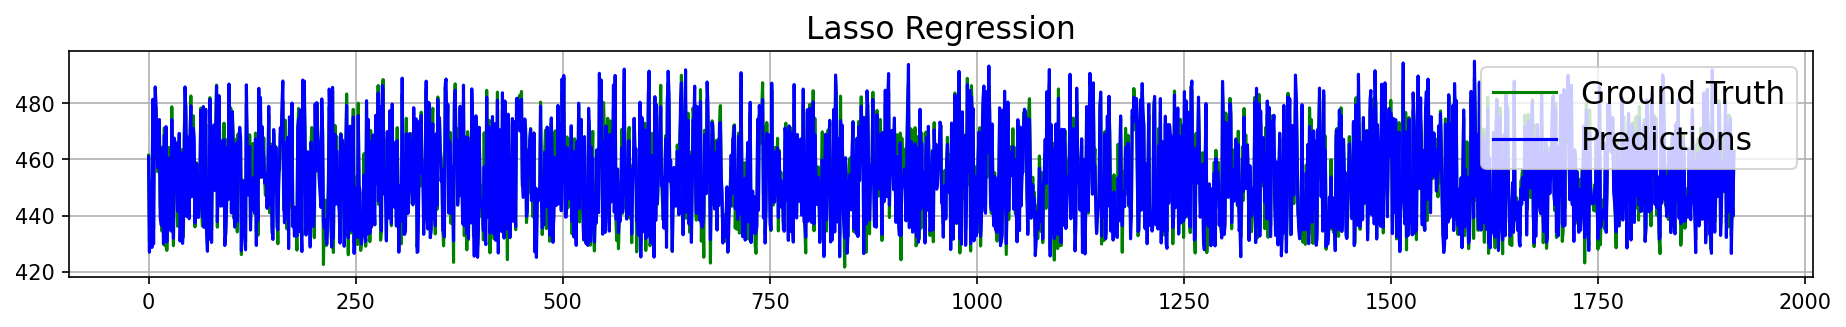

In [380]:
LR_L1_mBGD.plot_model(D_test, 'PE')

<b>ii)</b> L2-regularization,<br>

In [394]:
LR_L2_GD = LRGeneral(lambdaL1=0, lambdaL2=0.5, lr=0.01, nEpochs=100)
LR_L2_SGD = LRGeneral(bs=1, lambdaL1=0, lambdaL2=0.5, lr=0.01, nEpochs=100)
LR_L2_mBGD = LRGeneral(bs=100, lambdaL1=0, lambdaL2=0.5, lr=0.01, nEpochs=10)

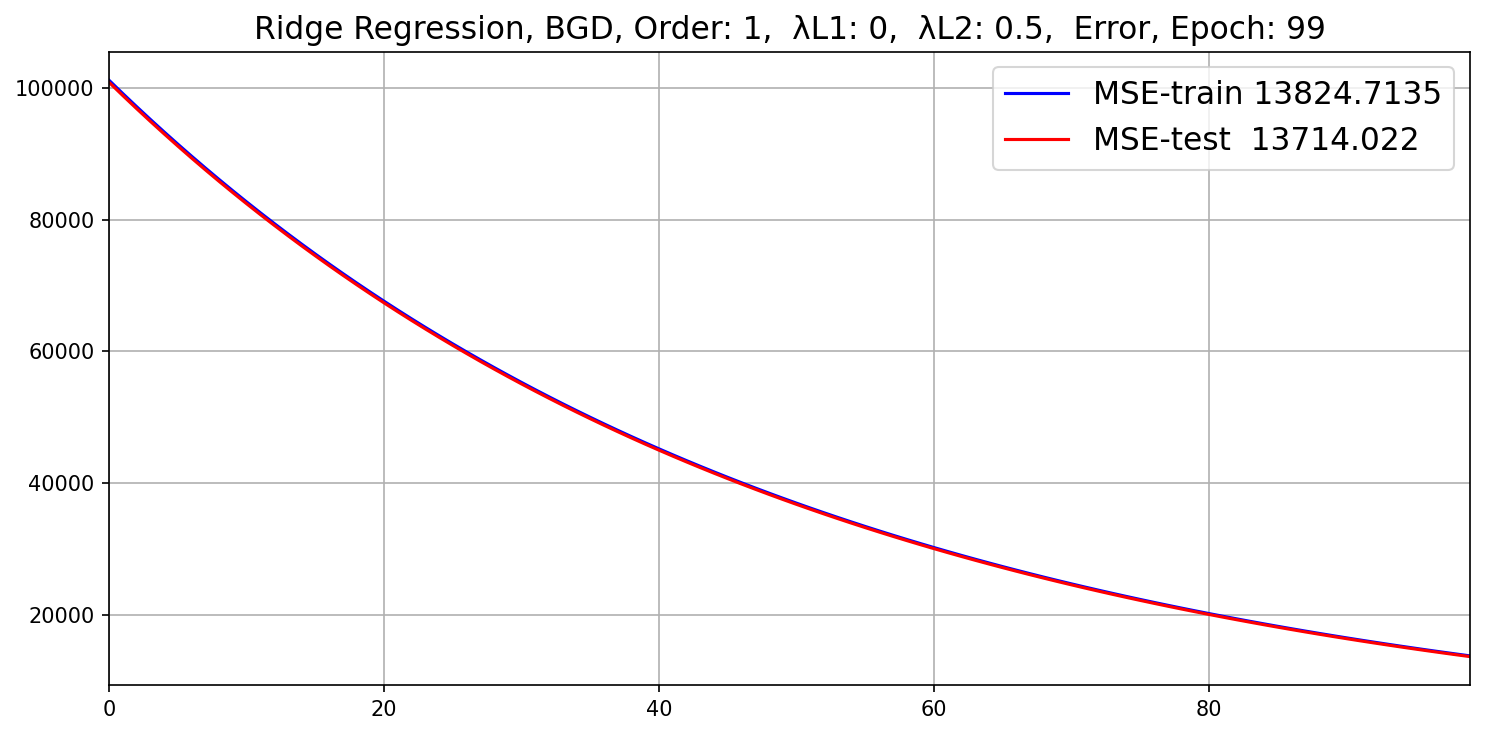

In [382]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_L2_GD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

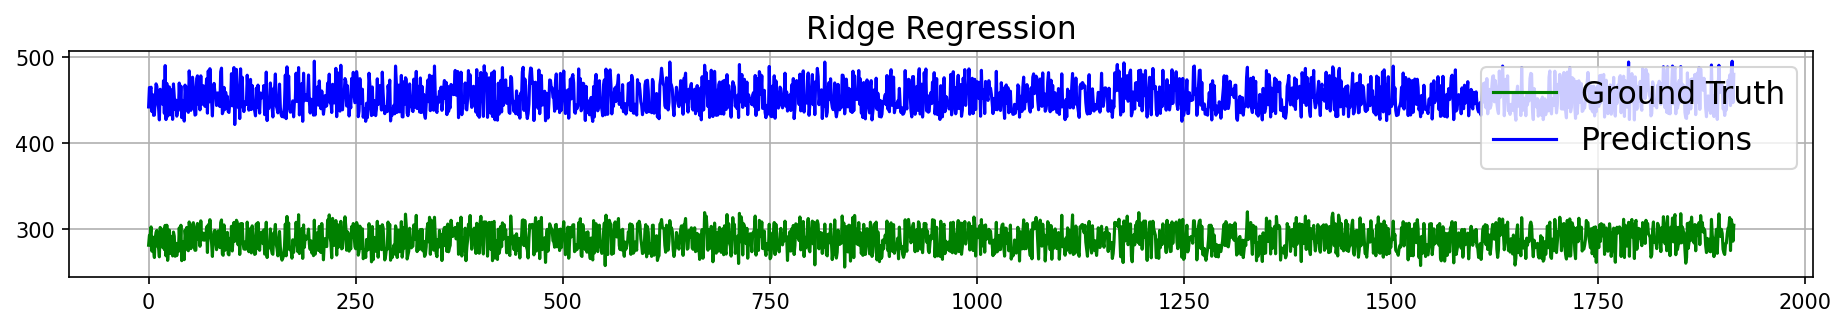

In [383]:
LR_L2_GD.plot_model(D_test, 'PE')

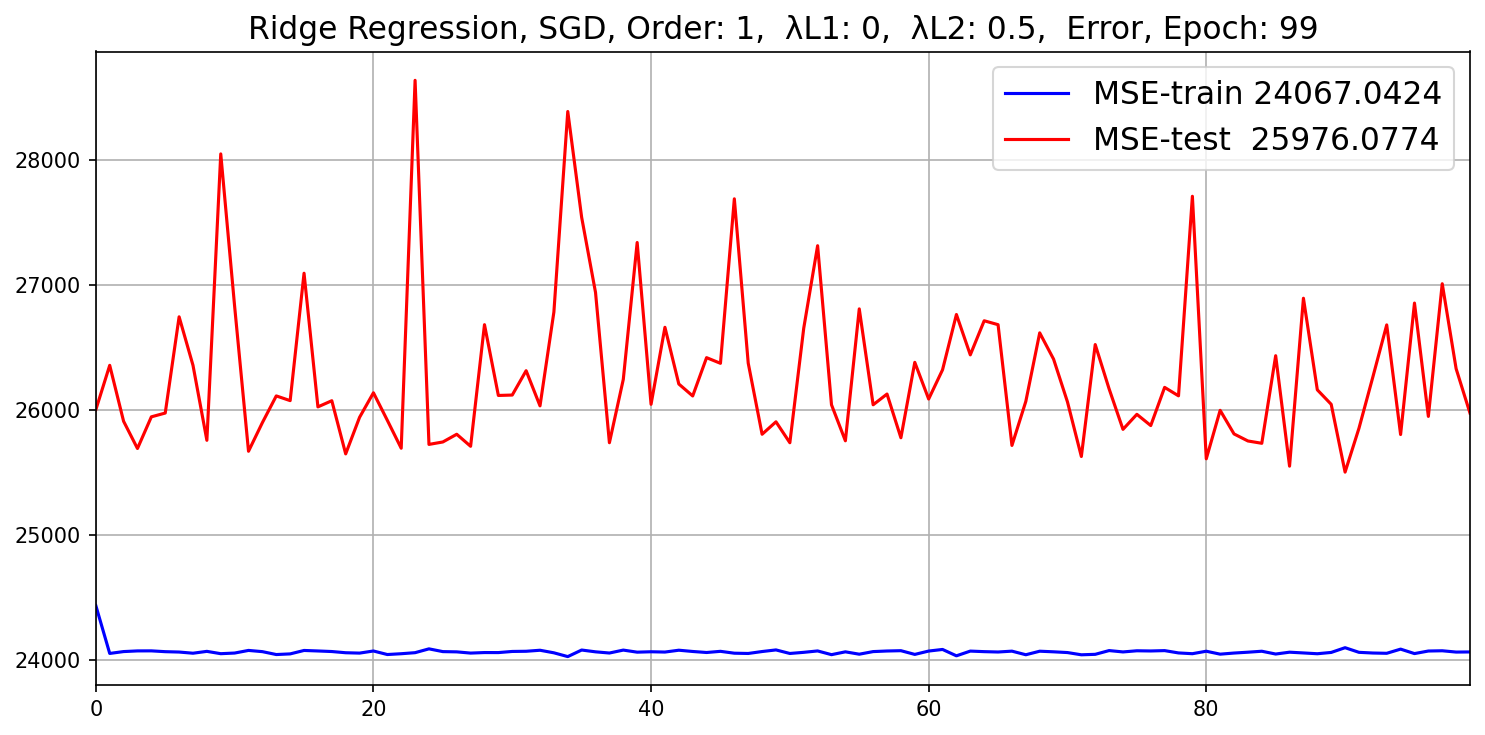

In [384]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_L2_SGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

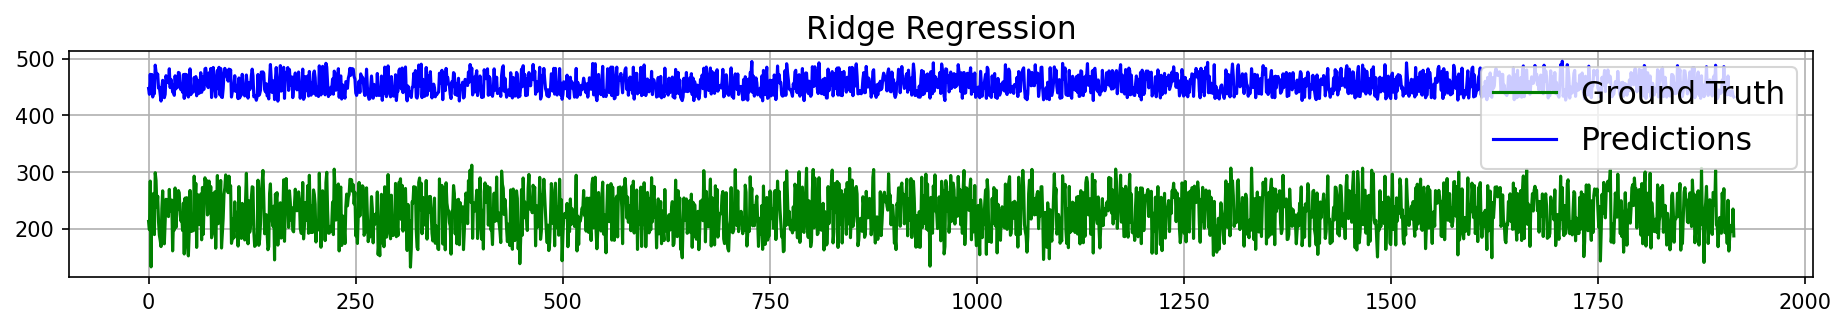

In [385]:
LR_L2_SGD.plot_model(D_test, 'PE')

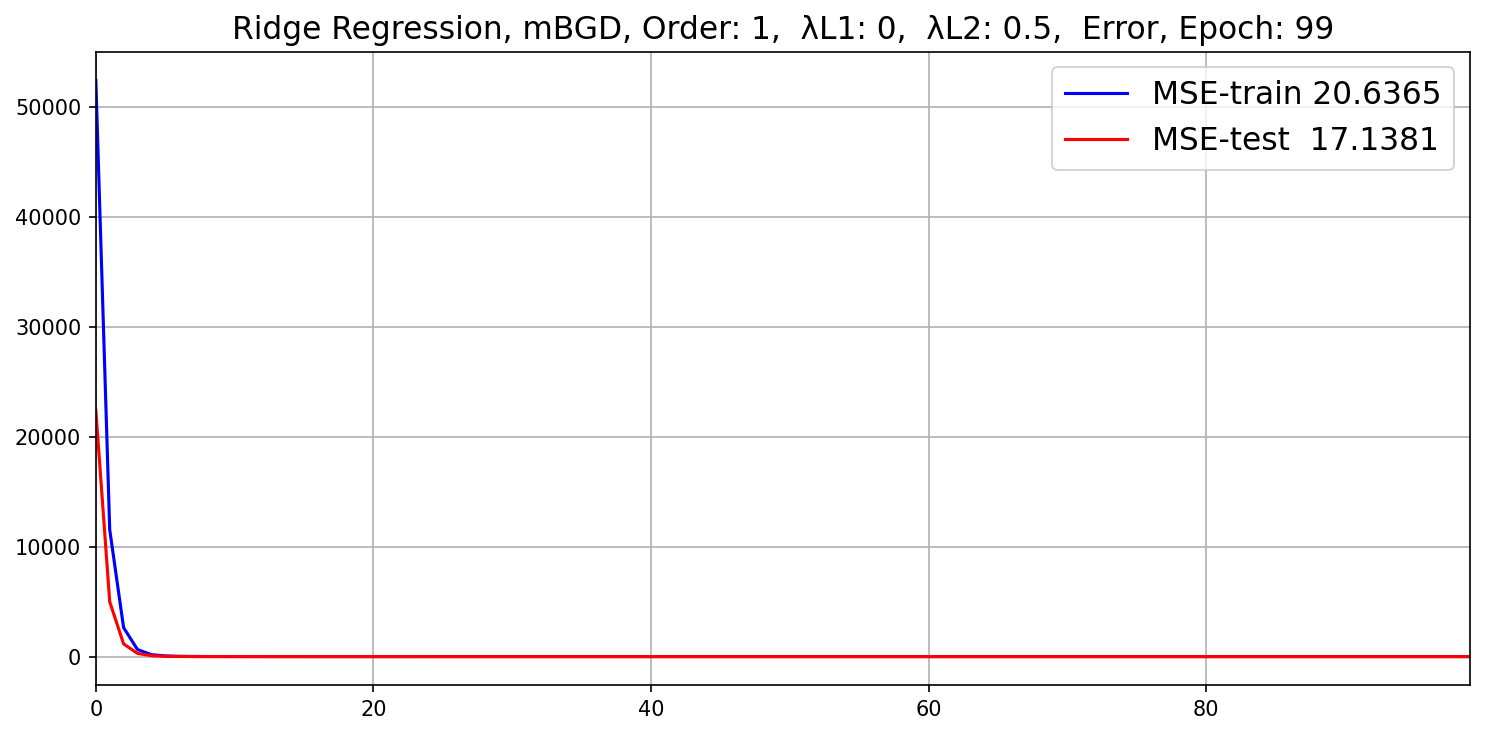

In [386]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_L2_mBGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

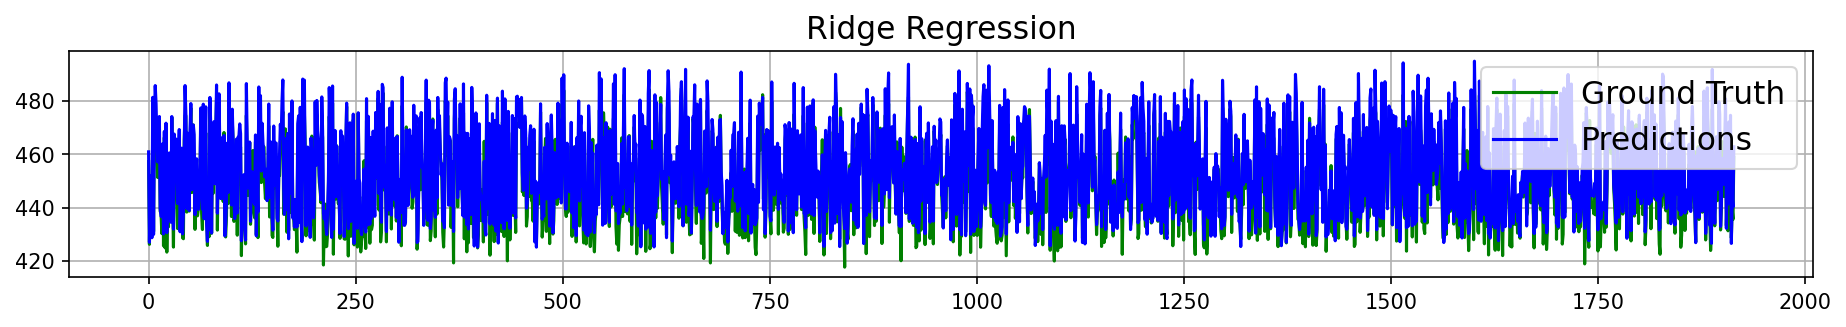

In [387]:
LR_L2_mBGD.plot_model(D_test, 'PE')

<b>iii)</b> Linear combination of L1 and L2 regularization: ${λ_{1}||θ||_{2}^2}$ + ${λ_{2}||θ||_{1}}$ 

In [396]:
LR_EN_GD = LRGeneral(lambdaL1=0.5, lambdaL2=0.5, lr=0.01, nEpochs=100)
LR_EN_SGD = LRGeneral(bs=1, lambdaL1=0.5, lambdaL2=0.5, lr=0.01, nEpochs=100)
LR_EN_mBGD = LRGeneral(bs=100, lambdaL1=0.5, lambdaL2=0.5, lr=0.01, nEpochs=10)

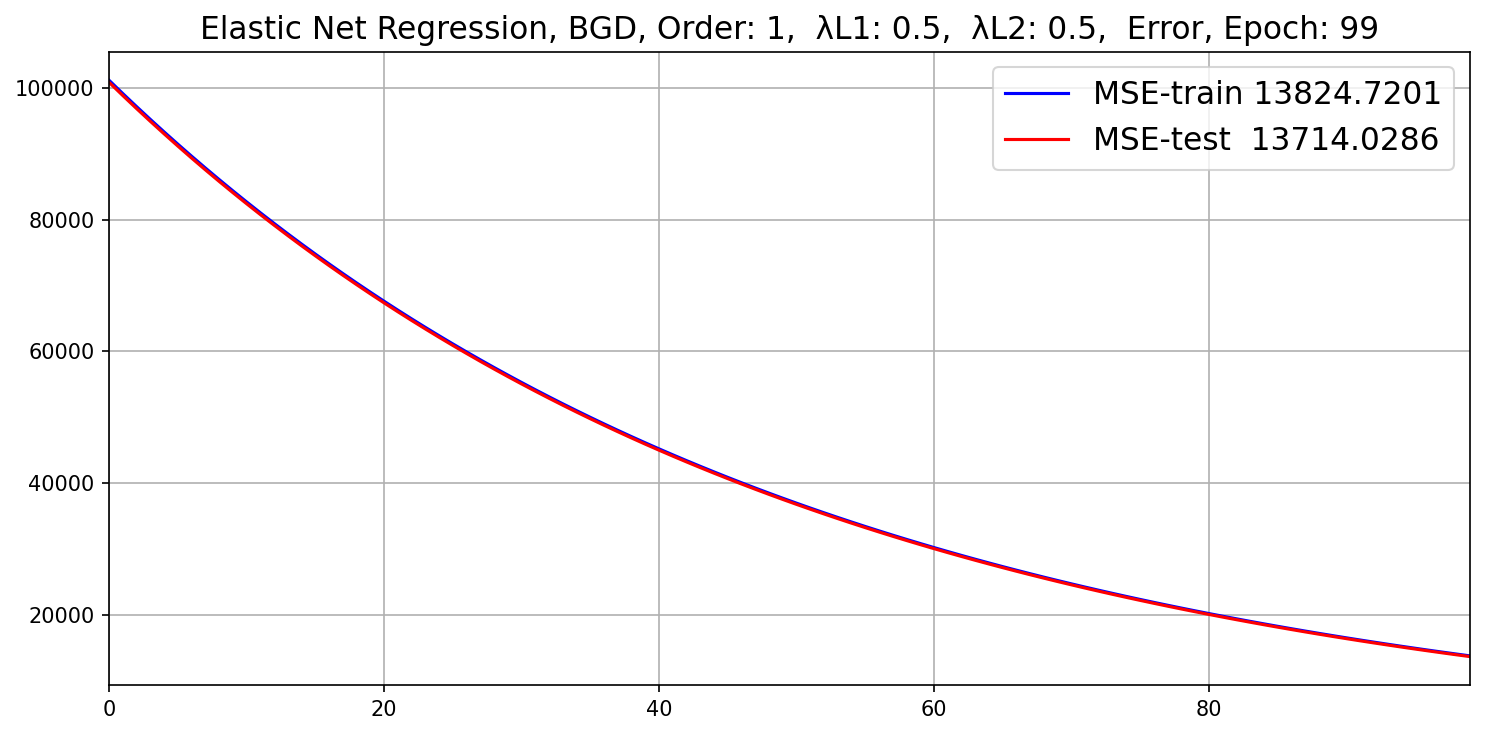

In [389]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_EN_GD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

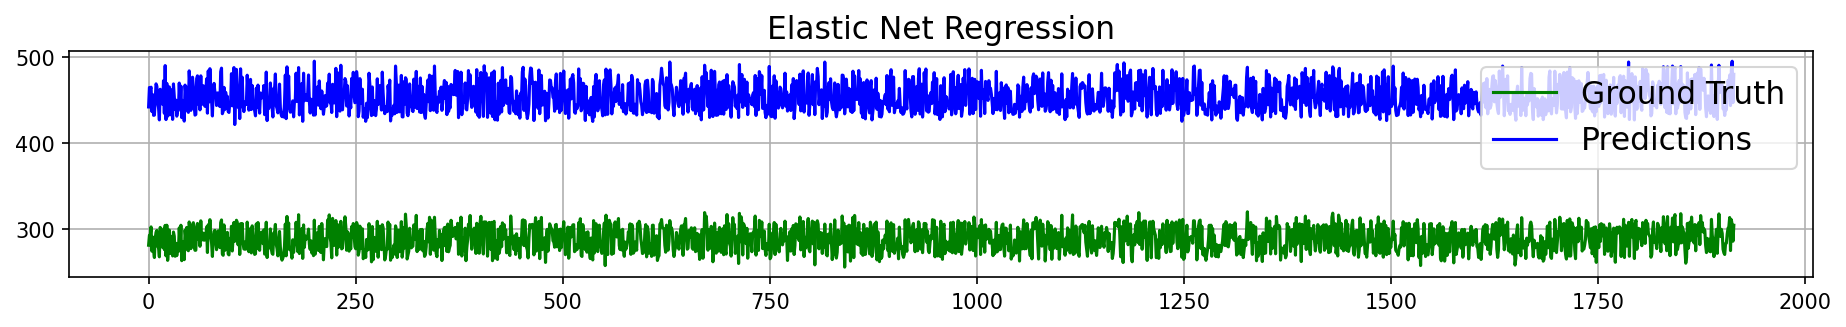

In [390]:
LR_EN_GD.plot_model(D_test, 'PE')

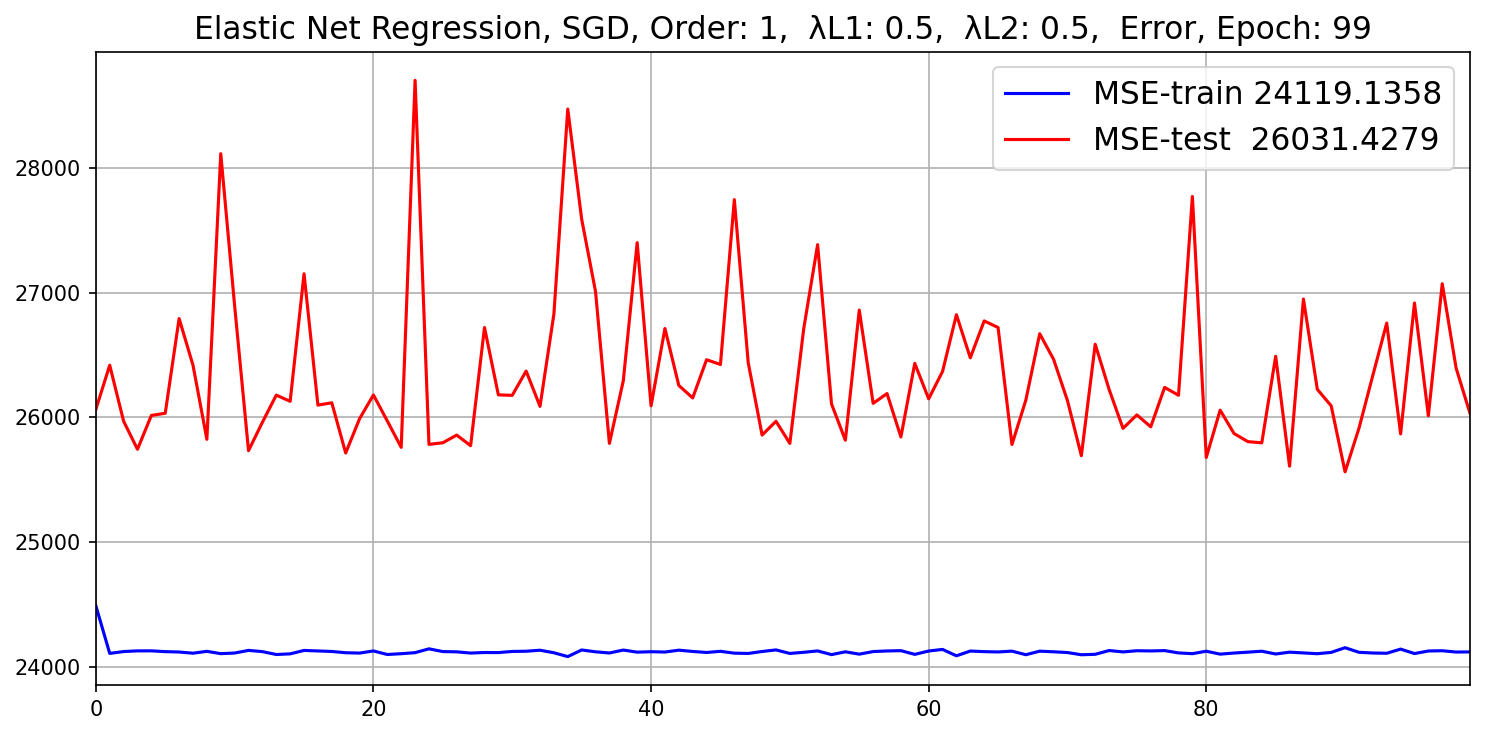

In [391]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_EN_SGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

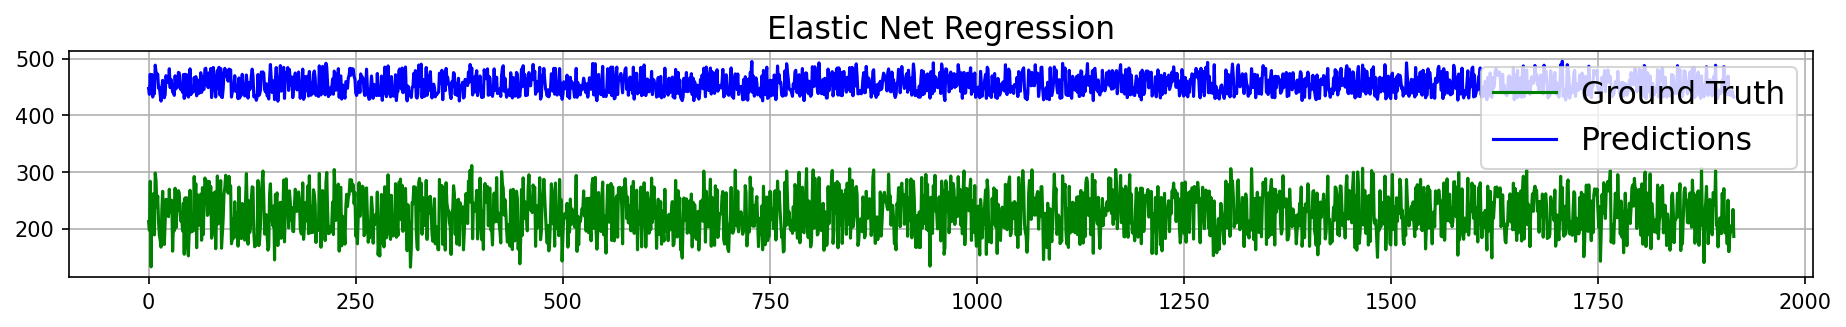

In [392]:
LR_EN_SGD.plot_model(D_test, 'PE')

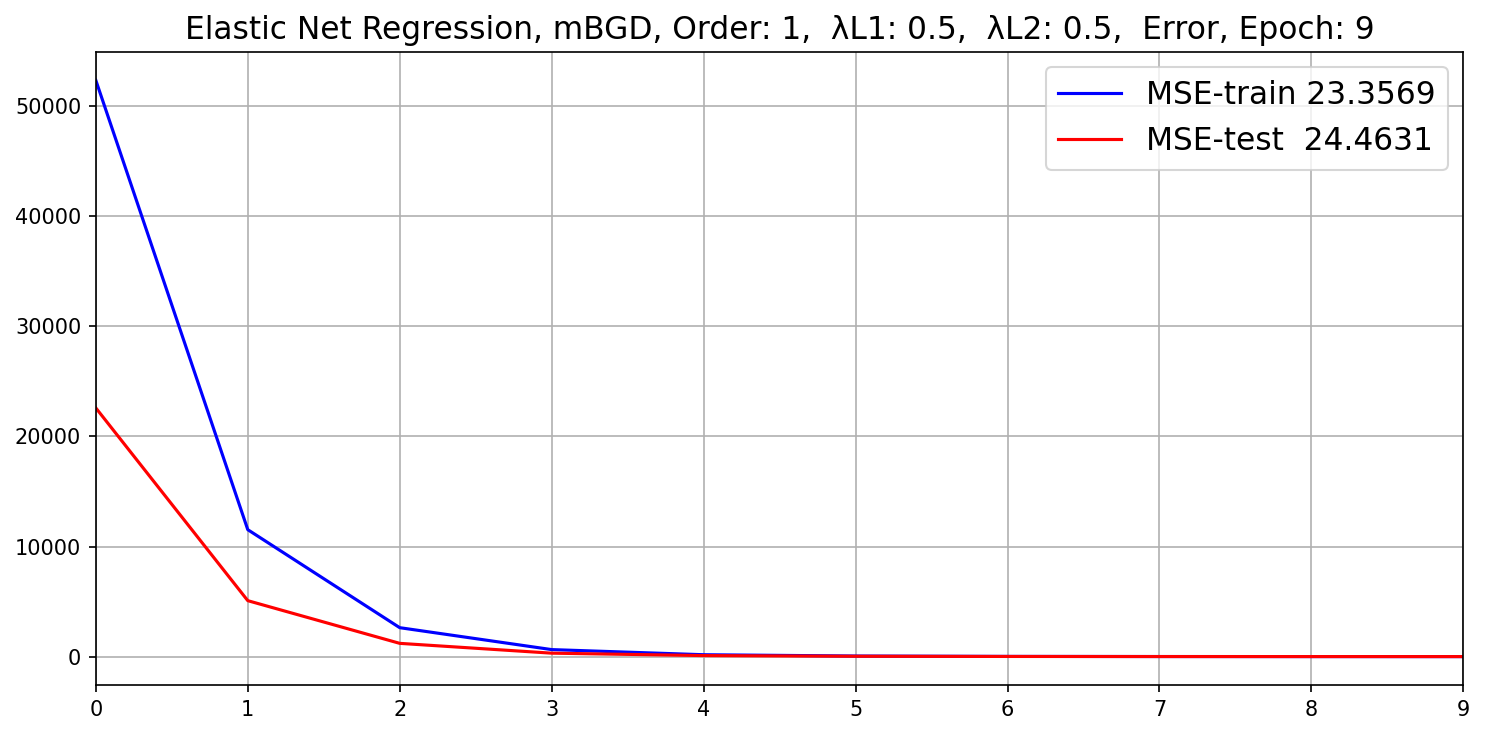

In [398]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_EN_mBGD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)

In [397]:
LR_EN_mBGD.plot_model(D_test, 'PE')

AttributeError: 'LRGeneral' object has no attribute 'theta'

<Figure size 2250x300 with 0 Axes>

<b>I.</b> For each model in (h), and using lambda in [-10, 10], fit the model and compute the norm of the weights.<br>
Plot the norm of the weights as a function of the regularization parameter.<br>
How does the norm of the weights behave with respect to the weights. (Ensure lambda=0 is among the set of lambda values)<br>

Print out the weights for the model with the highest norm and lowest norm.<br>
How does the values of the weights (elements of the weights vector) affect the norm?<br>

Print out the weights of an L1-regularization model and L2-regularization model.<br>
What is the difference between the weights? Which model has more sparse weights?

<b>[ Solution ]</b><br>
&emsp; I'll compute the L2-norm for the weights.

In [ ]:
lam_n = 20
lam_range = np.linspace(-10,10,lam_n)

#### L1-Regularization

LR_L1_GD<br>
LR_L1_SGD<br>
LR_L1_mBGD

In [ ]:
%matplotlib inline

In [ ]:
GD = []
SGD = []
mBGD = []

for lam1 in lam_range:
#     print('lambda ', lam1)
    LR_L1_GD = LRGeneral(lambdaL1=lam1, lambdaL2=0, lr=0.01, nEpochs=100)
    _, _, _, _, GDtheta = LR_L1_GD.fit(Data=CCPP,
                                       sp_pr=0.2,
                                       target='PE',
                                       loss=MSE,
                                       grad=gradEN,
                                       plot=False)
    LR_L1_SGD = LRGeneral(bs=1, lambdaL1=lam1, lambdaL2=0, lr=0.01, nEpochs=10)
    _, _, _, _, SGDtheta = LR_L1_SGD.fit(Data=CCPP,
                                         sp_pr=0.2,
                                         target='PE',
                                         loss=MSE,
                                         grad=gradEN,
                                         plot=False)
    LR_L1_mBGD = LRGeneral(bs=100, lambdaL1=lam1, lambdaL2=0, lr=0.01, nEpochs=10)
    _, _, _, _, mBGDtheta = LR_L1_mBGD.fit(Data=CCPP,
                                           sp_pr=0.2,
                                           target='PE',
                                           loss=MSE,
                                           grad=gradEN,
                                           plot=False)
    GD.append(LA.norm(GDtheta))
    SGD.append(LA.norm(SGDtheta))
    mBGD.append(LA.norm(mBGDtheta))

plt.figure(dpi=130)
plt.plot(lam_range, GD, 'r', label='GD')
plt.plot(lam_range, SGD, 'g', label='SGD')
plt.plot(lam_range, mBGD, 'b', label='mBGD')
plt.grid()
plt.legend(loc='upper right', fontsize=15)
# plt.title('L2-Norm of the Weights', fontsize=15)

#### L2-Regularization

LR_L2_GD<br>
LR_L2_SGD<br>
LR_L2_mBGD

In [ ]:
%matplotlib inline

In [ ]:
GD = []
SGD = []
mBGD = []

for lam2 in lam_range:
    LR_L2_GD = LRGeneral(lambdaL1=0, lambdaL2=lam2, lr=0.01, nEpochs=100)
    _, _, _, _, GDtheta = LR_L2_GD.fit(Data=CCPP,
                                       sp_pr=0.2,
                                       target='PE',
                                       loss=MSE,
                                       grad=gradEN,
                                       plot=False)
    LR_L2_SGD = LRGeneral(bs=1, lambdaL1=0, lambdaL2=lam2, lr=0.01, nEpochs=10)
    _, _, _, _, SGDtheta = LR_L2_SGD.fit(Data=CCPP,
                                         sp_pr=0.2,
                                         target='PE',
                                         loss=MSE,
                                         grad=gradEN,
                                         plot=False)
    LR_L2_mBGD = LRGeneral(bs=100, lambdaL1=0, lambdaL2=lam2, lr=0.01, nEpochs=10)
    _, _, _, _, mBGDtheta = LR_L2_mBGD.fit(Data=CCPP,
                                           sp_pr=0.2,
                                           target='PE',
                                           loss=MSE,
                                           grad=gradEN,
                                           plot=False)
    GD.append(LA.norm(GDtheta))
    SGD.append(LA.norm(SGDtheta))
    mBGD.append(LA.norm(mBGDtheta))

plt.figure(dpi=130)
plt.plot(lam_range, GD, 'r', label='GD')
plt.plot(lam_range, SGD, 'g', label='SGD')
plt.plot(lam_range, mBGD, 'b', label='mBGD')
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.title('L2-Norm of the Weights', fontsize=15)

#### Elastic Net

LR_EN_GD<br>
LR_EN_SGD<br>
LR_EN_mBGD

In [ ]:
from matplotlib import cm
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [ ]:
λL1, λL1 = np.meshgrid(lam_range, lam_range)

In [ ]:
GD = np.zeros([lam_n, lam_n])
SGD = np.zeros([lam_n, lam_n])
mBGD = np.zeros([lam_n, lam_n])
for i, l1 in enumerate(lam_range):
    for j, l2 in enumerate(lam_range):
        LR_EN_GD = LRGeneral(lambdaL1=l1, lambdaL2=l2, lr=0.01, nEpochs=10)
        _, _, _, _, GDtheta = LR_EN_GD.fit(Data=CCPP,
                                           sp_pr=0.2,
                                           target='PE',
                                           loss=MSE,
                                           grad=gradEN,
                                           plot=False)
        
        LR_EN_SGD = LRGeneral(bs=1, lambdaL1=l1, lambdaL2=l2, lr=0.01, nEpochs=10)
        _, _, _, _, SGDtheta = LR_EN_SGD.fit(Data=CCPP,
                                             sp_pr=0.2,
                                             target='PE',
                                             loss=MSE,
                                             grad=gradEN,
                                             plot=False)
        
        LR_EN_mBGD = LRGeneral(bs=100, lambdaL1=l1, lambdaL2=l2, lr=0.01, nEpochs=10)
        _, _, _, _, mBGDtheta = LR_EN_mBGD.fit(Data=CCPP,
                                               sp_pr=0.2,
                                               target='PE',
                                               loss=MSE,
                                               grad=gradEN,
                                               plot=False)
    
        GD[i, j] = LA.norm(GDtheta)
        SGD[i, j] = LA.norm(SGDtheta)
        mBGD[i, j] = LA.norm(mBGDtheta)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=120)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(λL1, λL1, GD, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel('λL1')
ax.set_ylabel('λL2')
ax.set_title('L2-Norm of GD')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=120)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(λL1, λL1, SGD, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel('λL1')
ax.set_ylabel('λL2')
ax.set_title('L2-Norm of SGD')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=120)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(λL1, λL1, mBGD, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel('λL1')
ax.set_ylabel('λL2')
ax.set_title('L2-Norm of mBGD')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Step 4: Exploring the model weights and hyperparameters

In the previous section, you observed the effect of different regularization methods on the model. In this section, you will see how the size of training and test data affects the model

<b>J.</b> Using Mini-batch GD, a 20% test size and a lr of 0.01, fit the training samples, and predict on the training samples and test samples. Store the MSE error for each epoch during training in an array. You can write a function to perform this.
Plot the train and test error as a function of the number of epochs. How does the error behave as the epoch increases?

<b>[ Solution ]</b><br>
&emsp; It has been done already, review Step 2.

<b>K.</b> Using Mini-batchGD and different split sizes in [0.1,0.9], fit the training samples,and predict on the training samples and test samples. Store the MSE error for each split in an array. Use any LR of your choice. You can write a function to perform this.<br>
Plot the train and test error as a function of the split sizes. How does the split size affect the errors?

In [ ]:
%matplotlib inline

In [ ]:
split_range = np.linspace(0.1,0.9,9)

In [ ]:
lr = 0.01
nEpochs = 1000
Train = []
Test = []

plt.figure(dpi=120)

for sp in split_range:
    LinReg_mBGD = LinearRegression(bs=100, lr=lr, nEpochs=nEpochs)
    D_train, mse_train,\
    D_test, mse_test,\
    theta = LinReg_mBGD.fit(Data=CCPP,
                       sp_pr=sp,
                       target='PE',
                       loss=MSE,
                       grad=gradMSE,
                       plot=False)
    Train.append(mse_train[-1])
    Test.append(mse_test[-1])

plt.plot(split_range, Train, label='Train')
plt.plot(split_range, Test, label='Test')
plt.xlabel('Split Size')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

In this section, we will add more features to the data to see the effect of overfitting on the data.

<b>L.</b>

<b>[ Solution ]</b><br>
&emsp; Add a method to the DataLoader class (e.g. add features)

<b>i)</b> Create extra new features of each existing feature by adding polynomial features of degree 2 to your data. This can be done by squaring each of your previous features and adding them to the Dataframe. Your total number of features should be 2N where N is the number of previous features. Call the new data, X_poly2.

&emsp; Move to <b>iv</b>

<b>ii)</b> Add new polynomial features of degree 3 of your initial features to the data. Call the data X_poly2_3.

&emsp; Move to <b>iv</b>

<b>iii)</b> Add new polynomial features of degree 4 of your initial features to the data. Call the data X_poly2_3_4.

&emsp; Move to <b>iv</b>

<b>iv)</b> Using a test size of 20%, calculate the MSE for train and test data using the different data X(initial data), X_poly2, X_poly2_3, X_poly2_3_4. Plot the train and test MSE against the degree of polynomial of the features. Use a fixed lambda value of zero. How does the degree affect fitting of the data?

&emsp; The process of increasing the oreder of features is automated back in the DataLoader class.<br>
&emsp; Next we will train these poly-models using a for loop.

In [313]:
sp_size = 0.2
lam1 = 0; lam2= 0
lr = 0.01
nEpochs = 5000
poly = 4

&emsp; Without plotting training process:

In [ ]:
Train = []
Test = []
plt.figure(dpi=120)

for n in range(1, poly+1):
    print('\nOrder: ', n)
    LR_EN_GD = LRGeneral(f_order=n, bias=True, lambdaL1=lam1, lambdaL2=lam2, lr=lr, nEpochs=nEpochs)
    D_train, mse_train,\
    D_test, mse_test,\
    theta = LR_EN_GD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=False)
    Train.append(mse_train[-1])
    Test.append(mse_test[-1])

plt.plot(list(range(1, poly+1)), Train, label='Train')
plt.plot(list(range(1, poly+1)), Test, label='Test')
plt.xlabel('Complexity')
plt.ylabel('MSE')
plt.xticks(list(range(1, poly+1)))
plt.legend()
plt.grid()
plt.show()

&emsp; Plotting training process:

In [ ]:
Train = []
Test = []
plt.figure(dpi=120)

for n in range(1, poly+1):
    print('Order: ', n)
    LR_EN_GD = LRGeneral(f_order=n, bias=True, lambdaL1=lam1, lambdaL2=lam2, lr=lr, nEpochs=nEpochs)
    D_train, mse_train,\
    D_test, mse_test,\
    theta = LR_EN_GD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)
    Train.append(mse_train[-1])
    Test.append(mse_test[-1])

plt.plot(list(range(1, poly+1)), Train, label='Train')
plt.plot(list(range(1, poly+1)), Test, label='Test')
plt.xlabel('Complexity')
plt.ylabel('MSE')
plt.xticks(list(range(1, poly+1)))
plt.legend()
plt.grid()
plt.show()

<b>v)</b> Select the X_poly2_3_4 dataset and regularize the model.<br>
What value of lambda gives the best model and the corresponding MSE on the validation data?

In [314]:
from matplotlib import cm
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [323]:
lam_n = 20
lam_range = np.linspace(-10,10,lam_n)
λL1, λL1 = np.meshgrid(lam_range, lam_range)

In [324]:
MSE_train = np.zeros([lam_n, lam_n])
MSE_test = np.zeros([lam_n, lam_n])
for i, l1 in enumerate(lam_range):
    for j, l2 in enumerate(lam_range):
        LR_EN_GD = LRGeneral(f_order=4, bias=True, lambdaL1=l1, lambdaL2=l2, lr=0.01, nEpochs=100)
        D_train, mse_train,\
        D_test, mse_test,\
        theta = LR_EN_GD.fit(Data=CCPP,
                           sp_pr=0.2,
                           target='PE',
                           loss=MSE,
                           grad=gradEN,
                           plot=False)
    
        MSE_train[i, j] = mse_train[-1]
        MSE_test[i, j] = mse_test[-1]

<IPython.core.display.Javascript object>


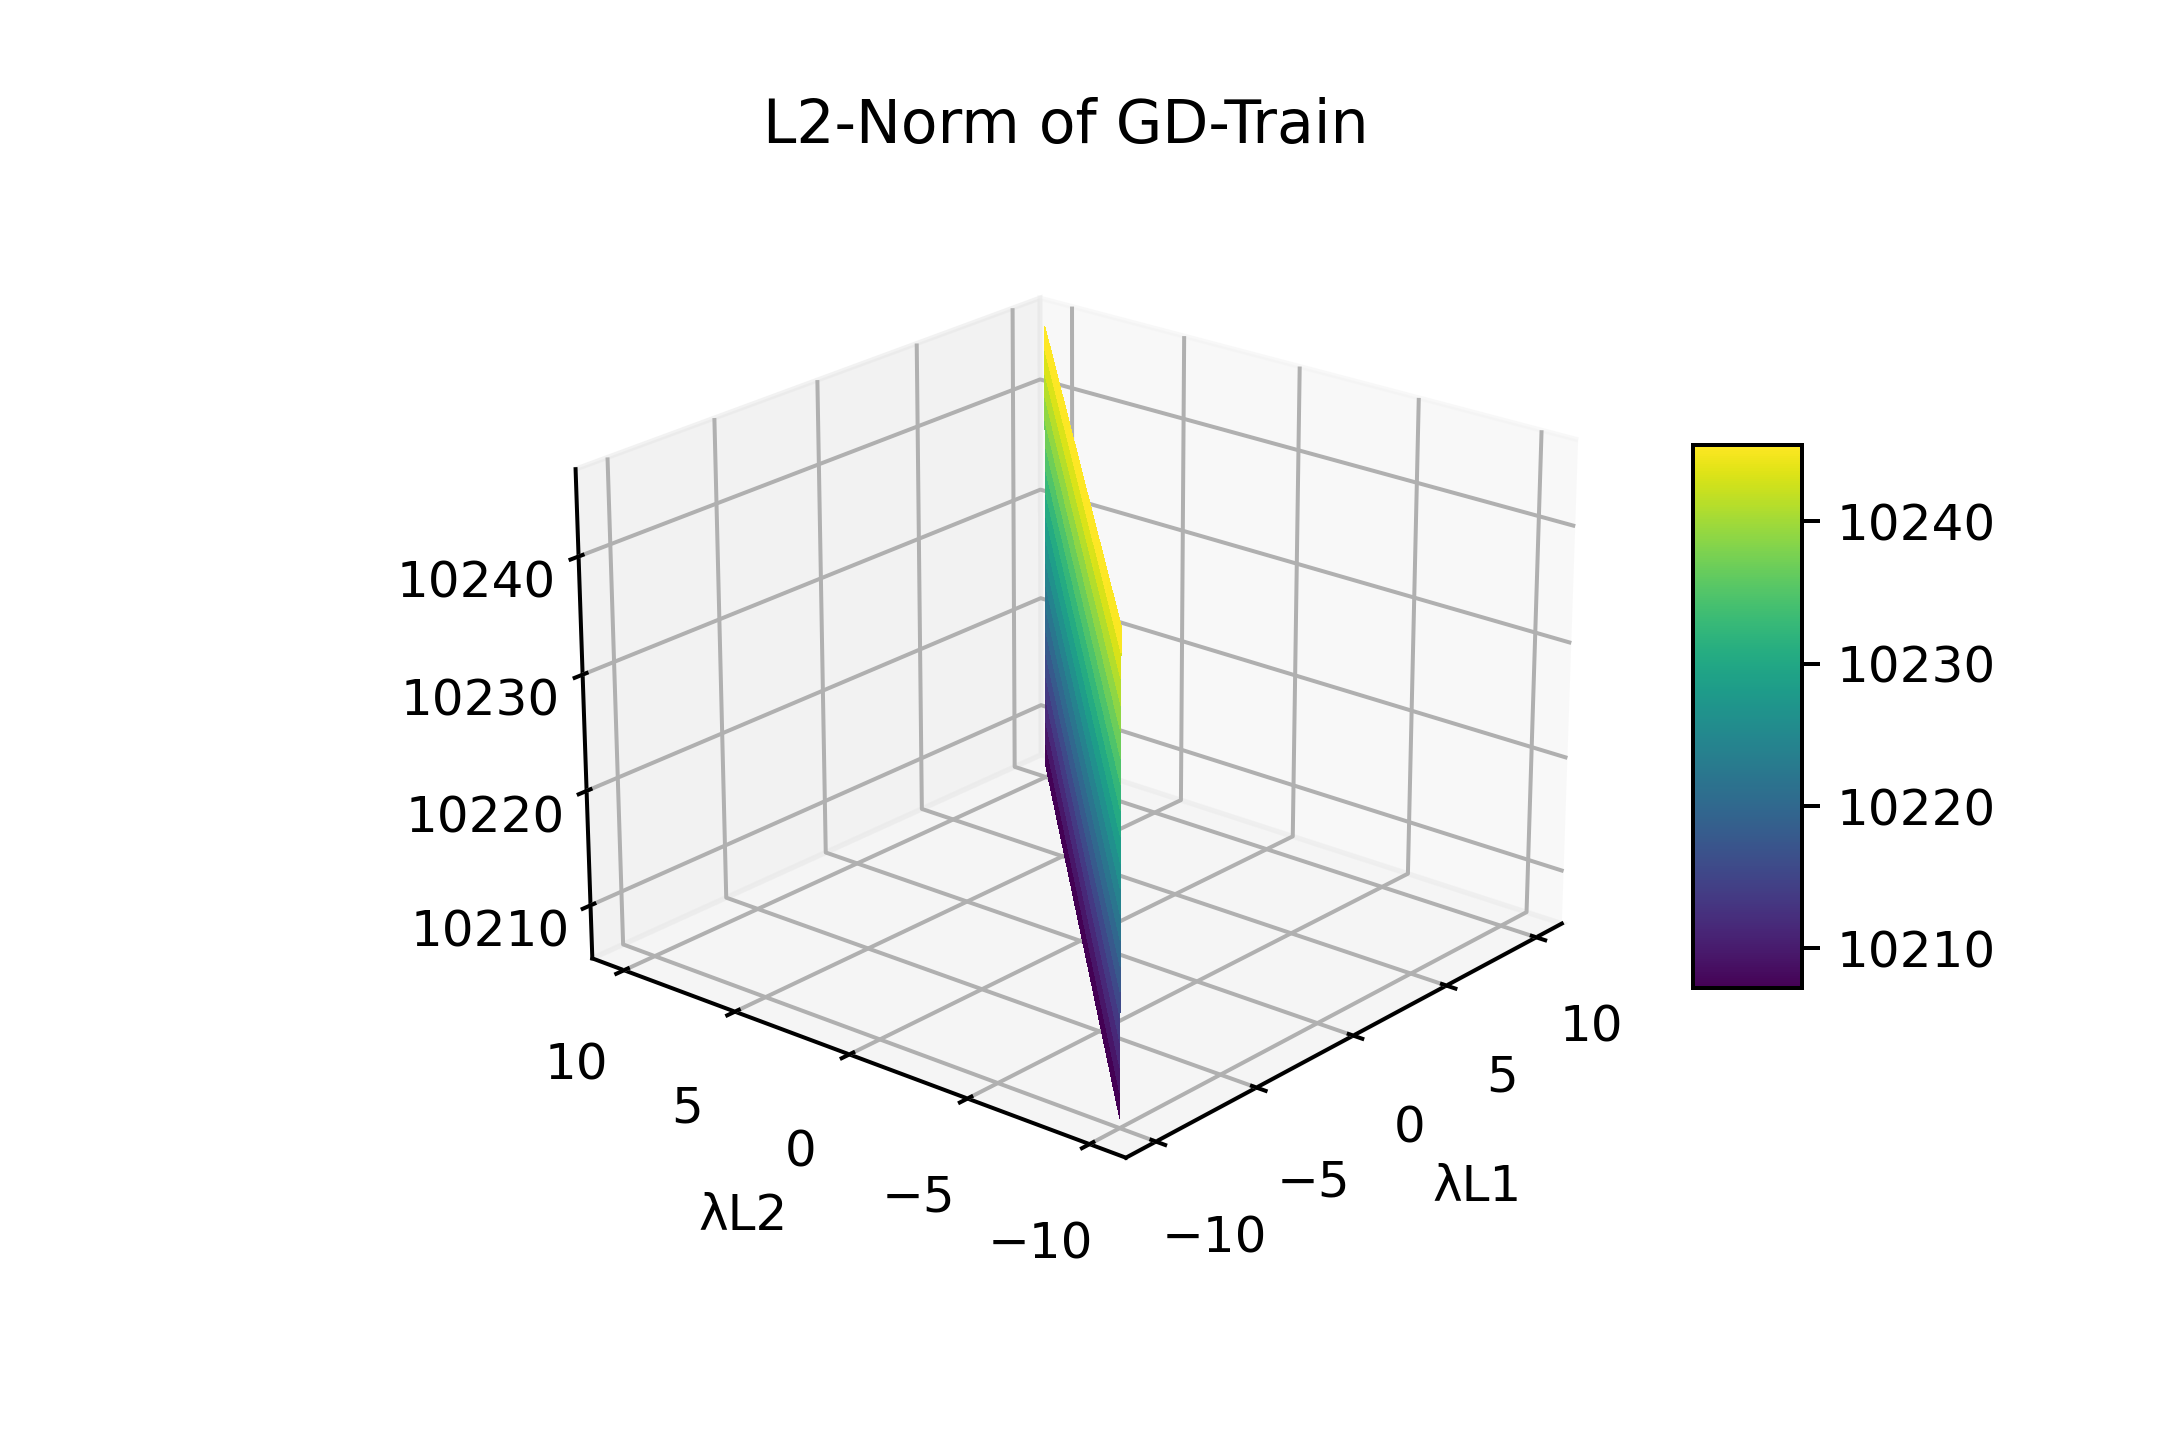

In [325]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=120)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(λL1, λL1, MSE_train, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel('λL1')
ax.set_ylabel('λL2')
ax.set_title('L2-Norm of GD-Train')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


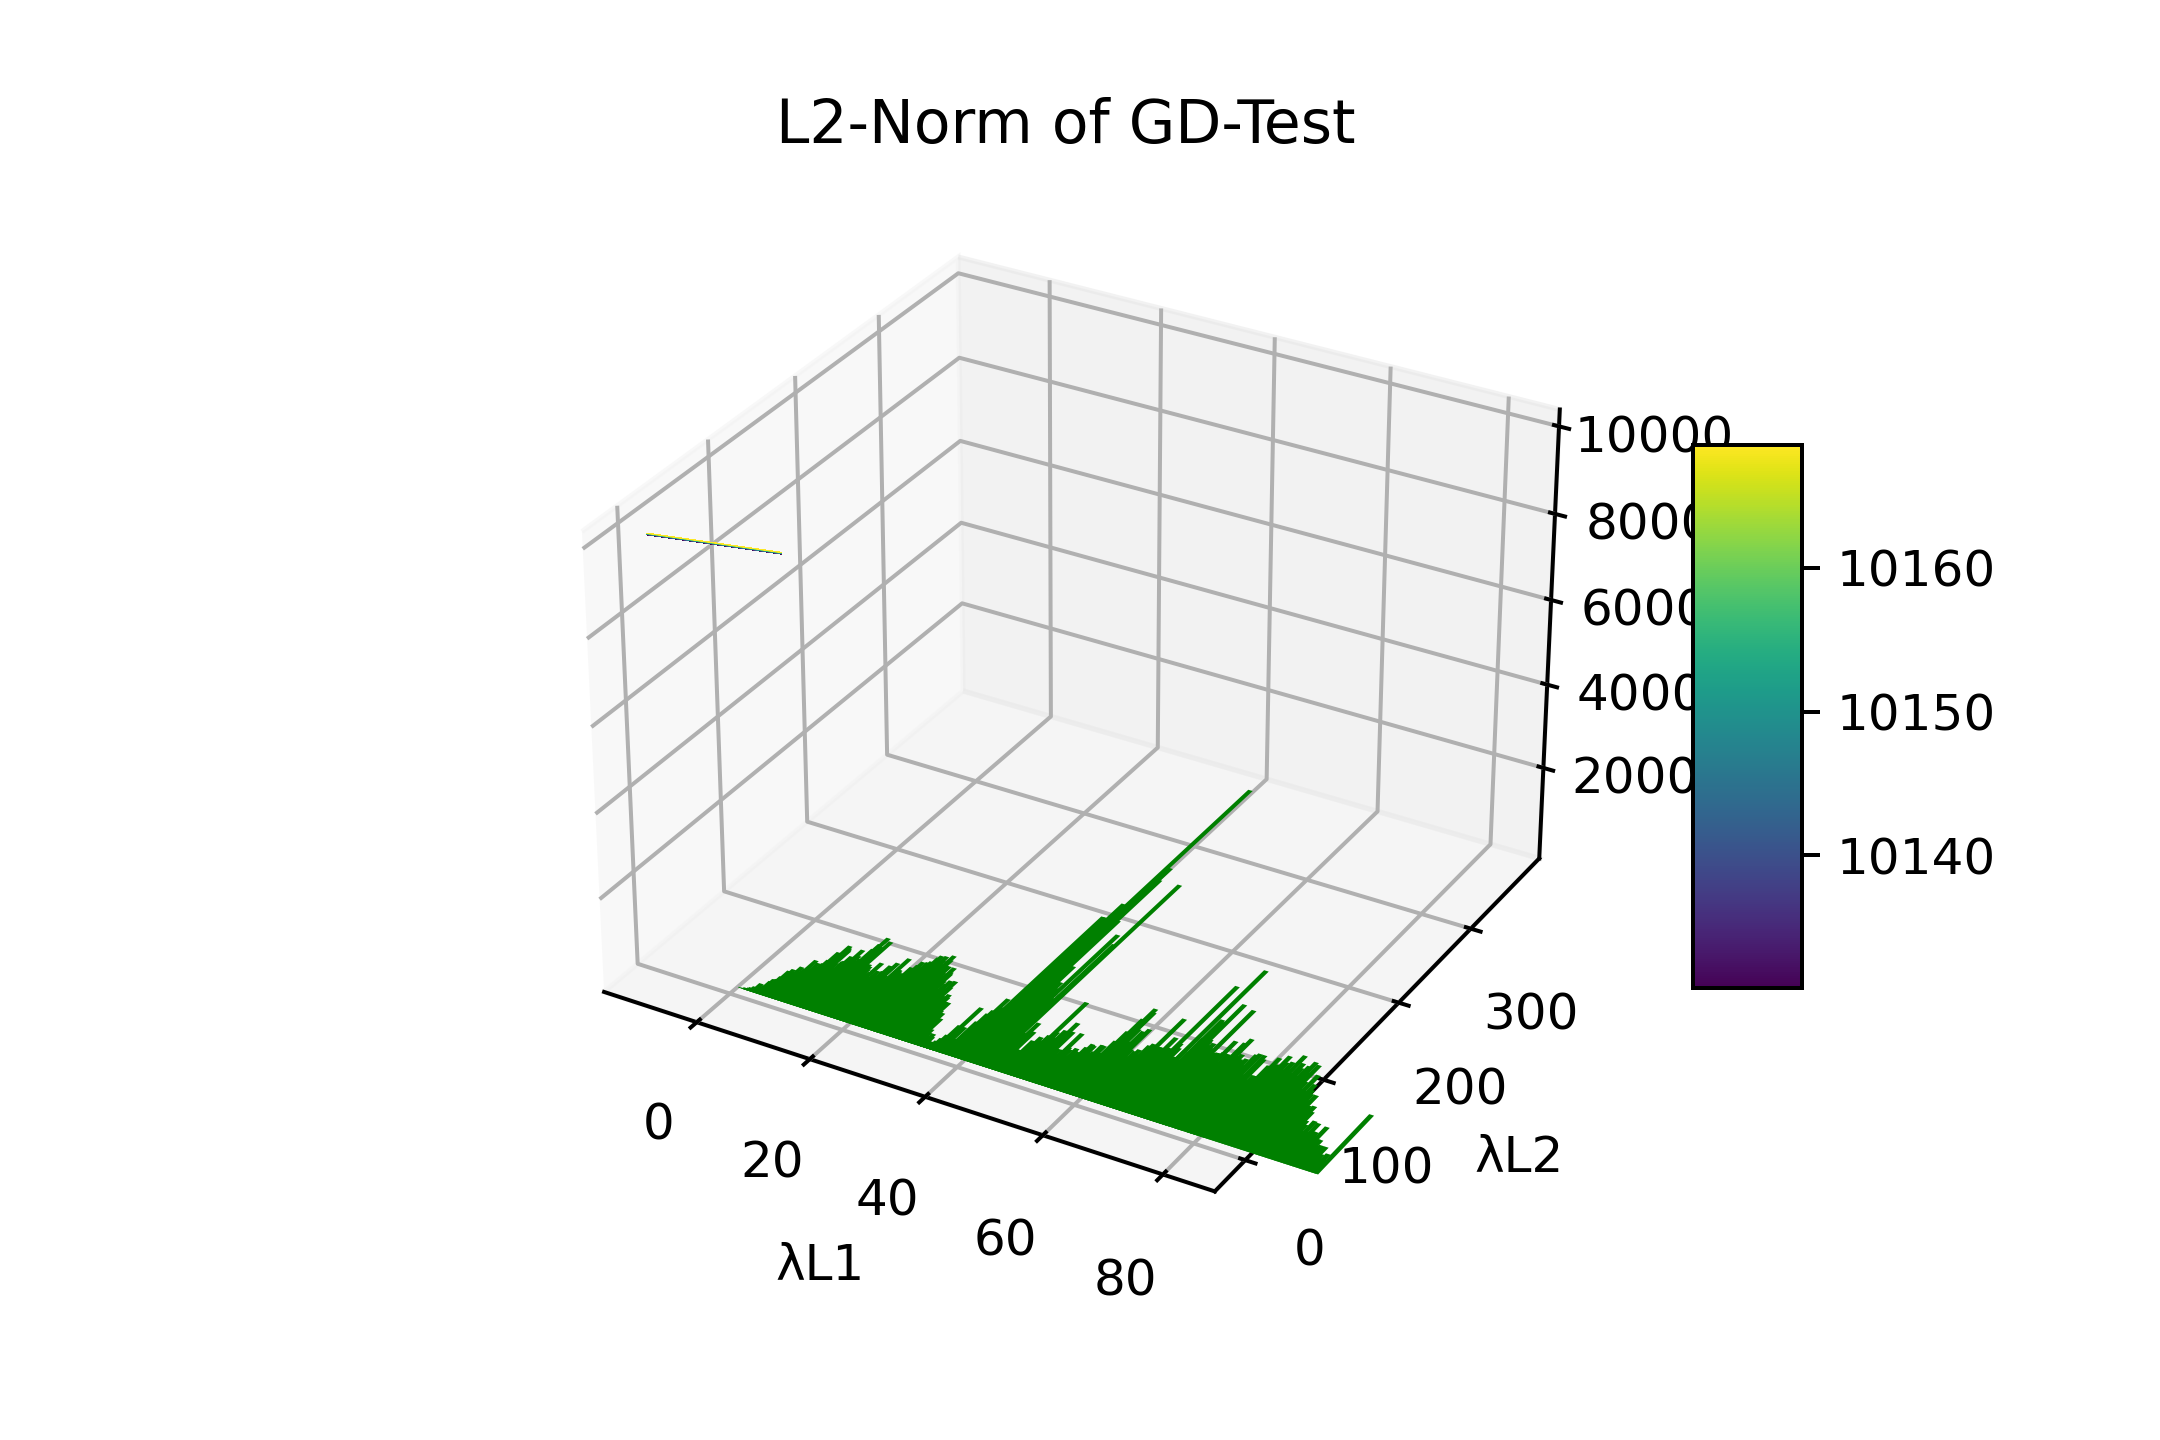

In [326]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=120)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(λL1, λL1, MSE_test, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel('λL1')
ax.set_ylabel('λL2')
ax.set_title('L2-Norm of GD-Test')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<b>[ Answer ]</b><br>
&emsp; As we can see from the above 3d-plot, a good range could lay in between ??[Run and Plot]??

Previously, we experimented with different degrees of polynomials to show how overfitting can affect our model generalization.<br>
In this section, we will look at the effect of learning rate on the model convergence.

<b>M.</b> Using <b>Mini-batch SGD</b> and learning rates in the range of [1e-9, 2], train your models for only 3 epoch and compute the training and test losses. Plot the losses as a function of your learning rate.<br>
How does the learning rate affect the convergence rate and loss of the model?<br>
In which learning rate regions, is the model underfitting?

In [308]:
lr_range = np.linspace(1e-9, 2, 200) # ~0 --> 2

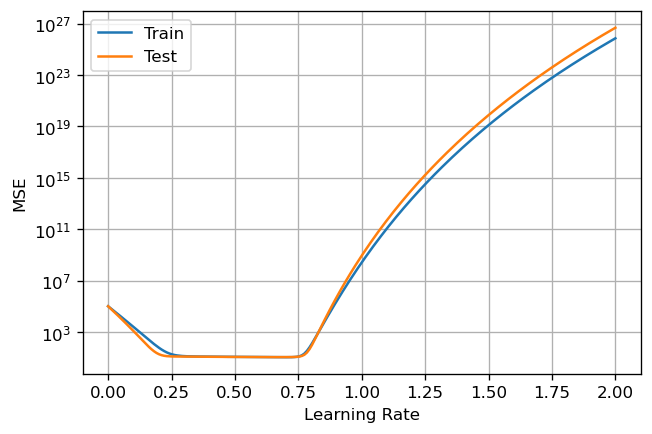

In [309]:
fig, ax = plt.subplots(dpi=120)

Train = []
Test = []
for lr in lr_range:
    LR_EN_GD = LRGeneral(bs=1000, bias=True, lr=lr, nEpochs=3)
    D_train, mse_train,\
    D_test, mse_test,\
    theta = LR_EN_GD.fit(Data=CCPP,
                         sp_pr=0.2,
                         target='PE',
                         loss=MSE,
                         grad=gradEN,
                         plot=False)
    Train.append(mse_train[-1])
    Test.append(mse_test[-1])

ax.plot(lr_range, Train, label='Train')
ax.plot(lr_range, Test, label='Test')

plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

<b>[ Answers ]</b><br>
&emsp; <b>a.</b> If the LR is too small, the model don't converge, and as it increases the model start to converge until we reach large values the model will deviate away from the optima and the error approach Infinity.<br>
&emsp; <b>b.</b> As we can see from the plot it underfits between 0.25 < LR < 0.75.

## Step 5: Perform Cross validation

<b>N)</b> The L1 and L2 penalties as we have observed from the previous task have proven to be some sort of “magic” hyper-parameters which we need to find in order to get a good performing model. We could alternatively, use the validation set approach, but this approach also has a major disadvantage: it leaves fewer samples available for training. Therefore, cross-validation is a better option to overcome this challenge by using all the training set in a smart way.
Implement your own cross-validation and find the best model based on the different values of lambda. Refer to your notes for the pseudocode.

In [212]:
class CrossVal:
    def __init__(self, base_model=None, kwargs=None, hyps=None):
        self.base_model = base_model
        self.kwargs = kwargs
        self.hyps = hyps # dict
    
    def set_models(self):
        Models = {}
        hyp1_name, hyp2_name = list(self.hyps.keys())[0], list(self.hyps.keys())[1]
        for hyp1_val in self.hyps[f'{hyp1_name}']:
            for hyp2_val in self.hyps[f'{hyp2_name}']:
                model = self.base_model(**self.kwargs, **{hyp1_name: hyp1_val}, **{hyp2_name: hyp2_val})
                Models[f'{hyp1_val},{hyp2_val}'] = model
        return Models
    
    def train(self, K, data, target, sp_pr, loss, grad, plot=False):
        Models = self.set_models()
        model_performance = {}
        for name, model in Models.items():
            mse_val = 0
            for k in range(1, K+1):
                train, val = dl.split_K(data, K, k)
                _, _, _, _, theta = model.fit(Data=train,
                                               sp_pr=sp_pr,
                                               target=target,
                                               loss=loss,
                                               grad=grad,
                                               plot=plot)
                mse_val += model.test_model(val, target, loss)
            model_performance[name] = mse_val/K
        best_hyp = min(model_performance, key=model_performance.get)
        return best_hyp
                
        

In [213]:
lam_n = 5
lam_range = np.linspace(-10,10,lam_n)
hyps = {'lambdaL1': lam_range, 'lambdaL2': lam_range}
kwargs = {'lr': 0.01, 'nEpochs': 100}

crossValidation = CrossVal(base_model=LRGeneral, kwargs=kwargs, hyps=hyps)

In [214]:
D_train, D_test = dl.split_data(CCPP, split_percent=0.2)

In [215]:
best_hyp = crossValidation.train(K=10, data=D_train, target='PE', sp_pr=0.2, loss=MSE, grad=gradEN)

Best values of λ:

In [231]:
best_hyp

'5.0, -10.0'

In [228]:
λL1, λL2 = float(best_hyp.split(',')[0]),  float(best_hyp.split(',')[1])

In [229]:
LR_EN_GD = LRGeneral(lambdaL1=λL1, lambdaL2=λL2, **kwargs)

Best model trained on the whole data:

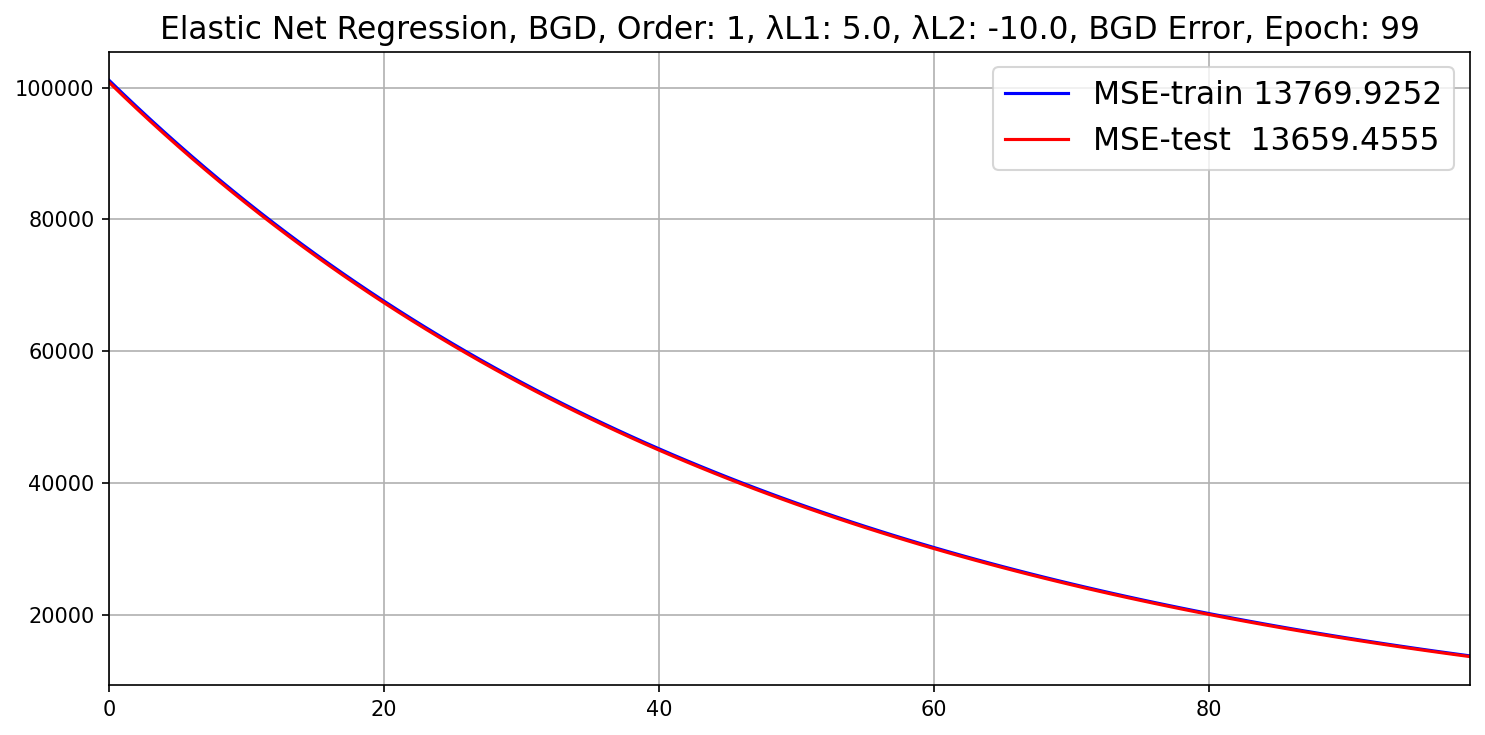

In [230]:
D_train, mse_train,\
D_test, mse_test,\
theta = LR_EN_GD.fit(Data=CCPP,
                       sp_pr=0.2,
                       target='PE',
                       loss=MSE,
                       grad=gradEN,
                       plot=True)